# <a id='0'> 목차 </a>

- <a href='#1'>Reference<a>
- <a href='#2'>패키지 등록 및 데이터 불러오기<a>
- <a href='#3'>Data Exploration<a>
    - <a href='#31'>데이터 확인 및 전처리<a>
    - <a href='#32'>타겟 변수와 각 데이터의 관계<a>
- <a href='#4'>Feature Engineering<a>
- <a href='#5'>Modeling<a>
    - <a href='#51'>XGBRegressor<a>
    - <a href='#52'>LGBMRegressor<a>
- <a href='#6'>2차 대회를 통해 느낀점<a>
    

# <a id='1'>Reference</a>  

> 척도의 종류와 의미 <br />
> https://blog.naver.com/moses3650/221202517582 <br />
> House Price Prediction EDA (updated 2019.03.12) <br />
> https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12 <br />
> XGBoost, Lightgbm ( catboost 예정 ) <br />
> https://www.kaggle.com/marchen911/xgboost-lightgbm

# <a id='2'>패키지 등록 및 데이터 불러오기</a>  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
IS_LOCAL = False

if IS_LOCAL:
    PATH="drive/colab/Kakr_2nd/data/"
else:
    PATH="../input/"

In [3]:
train = pd.read_csv(PATH+"train.csv")
test = pd.read_csv(PATH+"test.csv")

In [4]:
print("The Dataset's shape for train is {}, for test is {}".format(train.shape,test.shape))

The Dataset's shape for train is (15035, 21), for test is (6468, 20)


# <a id='3'>Data Exploration</a>  
## <a id='31'>데이터 확인 및 전처리</a>  

In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
id               15035 non-null int64
date             15035 non-null object
price            15035 non-null float64
bedrooms         15035 non-null int64
bathrooms        15035 non-null float64
sqft_living      15035 non-null int64
sqft_lot         15035 non-null int64
floors           15035 non-null float64
waterfront       15035 non-null int64
view             15035 non-null int64
condition        15035 non-null int64
grade            15035 non-null int64
sqft_above       15035 non-null int64
sqft_basement    15035 non-null int64
yr_built         15035 non-null int64
yr_renovated     15035 non-null int64
zipcode          15035 non-null int64
lat              15035 non-null float64
long             15035 non-null float64
sqft_living15    15035 non-null int64
sqft_lot15       15035 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 2.4+ MB


# 컬럼별 의미

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)


In [8]:
def draw_kdeplot(column):

    plt.figure(figsize=[8,6])
    
    sns.kdeplot(train[column],bw=0.5,label='train')
    sns.kdeplot(test[column],bw=0.5,label='test')
    
    plt.xlabel(column,fontsize=12)
    plt.title(f"Distribution of {column}",fontsize=20)
    plt.show()

In [9]:
def make_count_df(df,column):
    dummy = df.copy()
    result_df = dummy[column].value_counts().sort_index().to_frame().reset_index().rename(columns={"index":column,column:"counts"})
    return result_df

In [10]:
def compare_categorical_ratio(count_train,count_test,column,adjust_x_annotate=5,fontsize=14):
    fig, ax = plt.subplots(1,2,figsize=[12,6])
    
    ax1 = plt.subplot(1,2,1)
    sns.barplot(x=column,y='counts',data=count_train,label='train')

    for p in ax1.patches:
        ax1.annotate('{:.2f}%'.format(p.get_height()/count_train["counts"].sum()) , (p.get_x()+p.get_width()/adjust_x_annotate, p.get_height()),fontsize=fontsize)

    ax2 = plt.subplot(1,2,2)
    sns.barplot(x=column,y='counts',data=count_test,label='test')

    for p in ax2.patches:
        ax2.annotate('{:.2f}%'.format(p.get_height()/count_test["counts"].sum()) , (p.get_x()+p.get_width()/adjust_x_annotate, p.get_height()),fontsize=fontsize)

    plt.suptitle(f"Comparing btw train and test about {column}")
    plt.show()

## Date

날짜를 나타내는 Date 데이터에 대해 알아봅시다. 육안으로 봤을 때 T이하의 정보가 모두 동일해 보입니다. 년도/월/일 이하의 내용이 모두 동일해 보입니다. 한 번 확인해볼까요?? 

In [11]:
train.date.head(10)

0    20141013T000000
1    20150225T000000
2    20150218T000000
3    20140627T000000
4    20150115T000000
5    20150403T000000
6    20140527T000000
7    20140528T000000
8    20141007T000000
9    20150312T000000
Name: date, dtype: object

상위 10개의 값들만 확인해 봅시다. 우리가 유추한대로 비슷하다는 것을 알 수 있군요. 그렇다면 년/월/일 아래의 값들에 대해 자세히 알아봅시다.

In [12]:
train.date.apply(lambda x:str(x)[-7:]).value_counts()

T000000    15035
Name: date, dtype: int64

"T000000"이 무슨 뜻인지는 모르겠지만 아마도 시분초별로 두 자리씩 배정되어 있는 것 같습니다. 그리고 Date를 5개만 출력해보았을 때 순서대로 정렬되어 있는 것 같지도 않습니다. 일단은 Date를 위해 나중에 변환이 필요할 것 같습니다.

# Price
가격은 우리가 예측하고자 하는 타겟 값으로써 모델 형성시 들어가게될 label값이 될 것입니다. 가격에 대해서는 분포를 알아봅시다.

In [13]:
print("Minimum value of Price is {}, Maximum value of Price is {}".format(train.price.min(),train.price.max()))

Minimum value of Price is 78000.0, Maximum value of Price is 7700000.0


Price의 최소값은 7만 8천달러이며, 최대 값은 최소 값보다 100배 높은 770만달러입니다. 

Text(0.5, 1.0, 'Distribution of Price value')

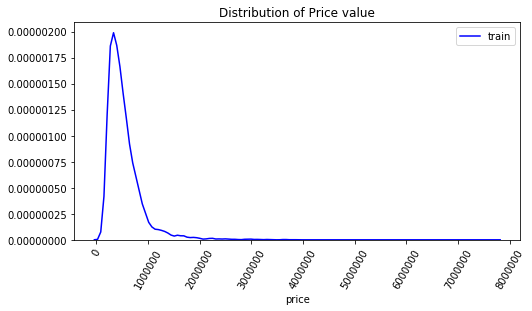

In [14]:
plt.figure(figsize=[8,4])
sns.distplot(train.price,hist=False,label='train',color='blue')
plt.xticks(rotation=60)
plt.title("Distribution of Price value")

가격의 분포를 보면 좌측으로 치우친 분포를 볼 수 있습니다. 보통 이렇게 치우친 값에 대해서 평가지표로 RMSLE를 사용하는데 우리의 문제에서는 단지 RMSE를 사용하고 있습니다.

# Bedrooms
이 컬럼은 집에서 침실의 수를 나타냅니다. 침실의 수는 보통 정수형으로 표현될 것 같고 소숫점값이 기대되지 않고 방의 개수 또한 한정적일 것이기 때문에 척도들 중에서 명목척도에 해당할 것 같습니다. 한 번 알아볼까요? 

In [15]:
train.bedrooms.value_counts().sort_index()

0        4
1      133
2     1931
3     6835
4     4797
5     1108
6      188
7       22
8       10
9        5
10       2
Name: bedrooms, dtype: int64

In [16]:
bedroom_train = make_count_df(train,"bedrooms")
bedroom_test = make_count_df(test,"bedrooms")

Text(0.5, 1.0, 'Number of Bedrooms')

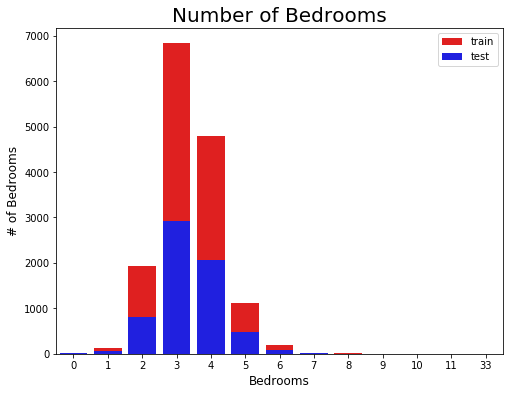

In [17]:
plt.figure(figsize=[8,6])

# ax = train.bedrooms.value_counts().sort_index().to_frame().plot(kind='bar',linewidth=2,figsize=[8,6])
# for p in ax.patches:
#     ax.annotate(p.get_height(), (p.get_x()-0.05, p.get_height()))

sns.barplot(x='bedrooms',y='counts',data=bedroom_train,label='train',color='red')
sns.barplot(x='bedrooms',y='counts',data=bedroom_test,label='test',color='blue')
plt.legend()
plt.ylabel("# of Bedrooms",fontsize=12)
plt.xlabel("Bedrooms",fontsize=12)

plt.title("Number of Bedrooms",fontsize=20)

# Bathrooms
 침실의 개수당 화장실 수를 나타냅니다 (화장실수 / 침실수). 왜 침실의 개수 당 화장실 수를 나타냈는지는 모르겠지만, 화장실의 개수도 집값에 영향을 미치지 않을까요?? 부잣집 친구집에 가면 화장실이 3개나 있는 것 처럼요!! 그렇다면 이를 이용하면 순수한 화장실의 수도 도출할 수 있겠죠?

In [18]:
train.bathrooms.value_counts().head()

2.50    3748
1.00    2675
1.75    2112
2.25    1433
2.00    1357
Name: bathrooms, dtype: int64

침실수로 나누기를 수행하다 보니 소수점 값이 생겨버렸군요 그렇다면 kdeplot을 통해서 훈련셋과 테스트셋의 분포가 유사한지 한번 살펴봅시다.

Text(0.5, 1.0, 'Distribution of Bathrooms(# of Bathrooms / # of Bedrooms)')

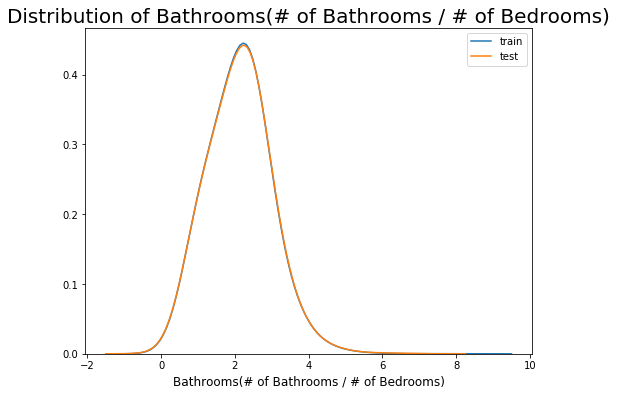

In [19]:
plt.figure(figsize=[8,6])

sns.kdeplot(train.bathrooms,bw=0.5,label='train')
sns.kdeplot(test.bathrooms,bw=0.5,label='test')

plt.xlabel("Bathrooms(# of Bathrooms / # of Bedrooms)",fontsize=12)
plt.title("Distribution of Bathrooms(# of Bathrooms / # of Bedrooms)",fontsize=20)

Bathroom 지표는 훈련셋과 테스트셋이 유사한 분포를 따르고 있는 것 같군요.

그렇다면 침실수를 곱해서 실제 화장실의 수를 한 번 파악해 볼까요??

In [20]:
train.bathrooms.mul(train.bedrooms).head()

0    3.00
1    2.00
2    6.00
3    6.75
4    4.50
dtype: float64

In [21]:
print("The min number of real bathroom is {}, max number of real bathroom is {}".format(train.bathrooms.mul(train.bedrooms).min(),train.bathrooms.mul(train.bedrooms).max()))

The min number of real bathroom is 0.0, max number of real bathroom is 67.5


침실수를 곱해주면 모두 정수화 할 수 있을 것 같았는데 아니였군요!! 그리고 화장실의 수가 67.5개나 있는 집이 있다니... 아무리 넓어도 불가능할 것 같기 때문에 진짜 화장실 개수를 도출하지는 않도록 합시다.

# sqft_living, sqft_lot
sqft_living은 집의 주거공간의 면적을 의미하며 lot은 주거공간을 포함한 차고, 마당 등의 공간이 포함된 것으로 보입니다. 다른 여타 컬럼들과 같이 해당 컬럼에 대해 훈련셋과 테스트셋의 분포를 살펴볼까요?

Text(0.5, 0.98, 'Distribution of sqft_living and sqft_lot')

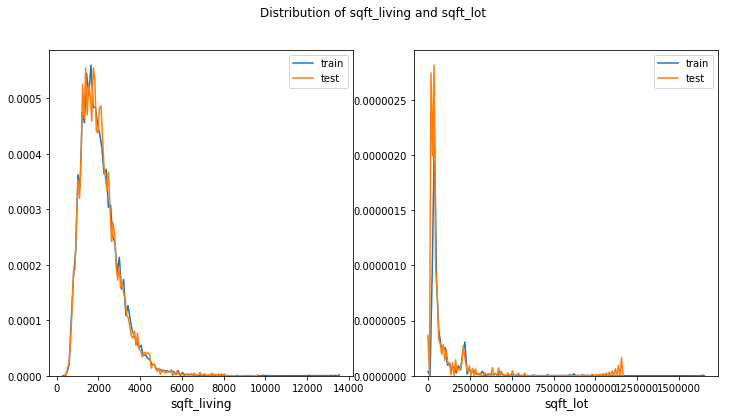

In [22]:
fig,ax = plt.subplots(1,2,figsize=[12,6])

ax1 = plt.subplot(1,2,1)
sns.kdeplot(train.sqft_living,bw=0.5,label="train")
sns.kdeplot(test.sqft_living,bw=0.5,label='test')
ax1.set_xlabel("sqft_living",fontsize=12)

ax2 = plt.subplot(1,2,2)
sns.kdeplot(train.sqft_lot,bw=0.5,label="train")
sns.kdeplot(test.sqft_lot,bw=0.5,label='test')
ax2.set_xlabel("sqft_lot",fontsize=12)

plt.suptitle("Distribution of sqft_living and sqft_lot")

주거공간과 총 면적은 뭔가 둘 간의 유사성이 있을거라고 직관적으로 생각이 듭니다만 나중에 계속 생각해보도록 합시다.

# Floor
집의 층수를 나타냅니다. 이 특징은 모두 정수로 구성되어 있으며 한번 층수의 분포를 살펴보도록 합시다.

In [23]:
train.floors.value_counts()

1.0    7361
2.0    5810
1.5    1330
3.0     417
2.5     113
3.5       4
Name: floors, dtype: int64

저는 아파트 또한 포함될 것 같았지만 층수의 높이를 보니 단독주택만 우리의 데이터셋에 포함된 듯합니다. 그리고 예상과달리 소숫점이 0.5 단위로 있는데, 제 생각에는 다락방 같은 것들을 .5층으로 생각했지 않을까 싶습니다.

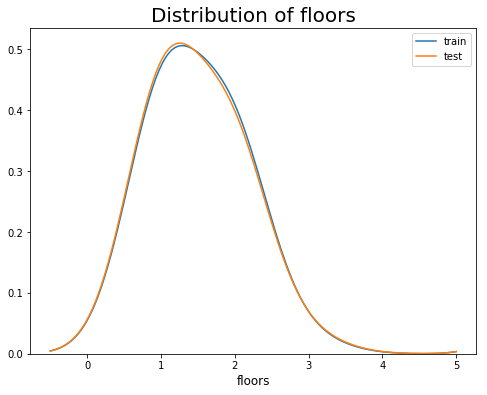

In [24]:
draw_kdeplot("floors")

floors의 분포 또한 훈련셋과 테스트셋이 유사하다는 것을 알 수 있습니다.

# WaterFront
집 앞에 강이 흐르는지 안 흐르는지 여부를 나타냅니다.

In [25]:
waterfront_train = make_count_df(train,"waterfront")
waterfront_test = make_count_df(test,"waterfront")

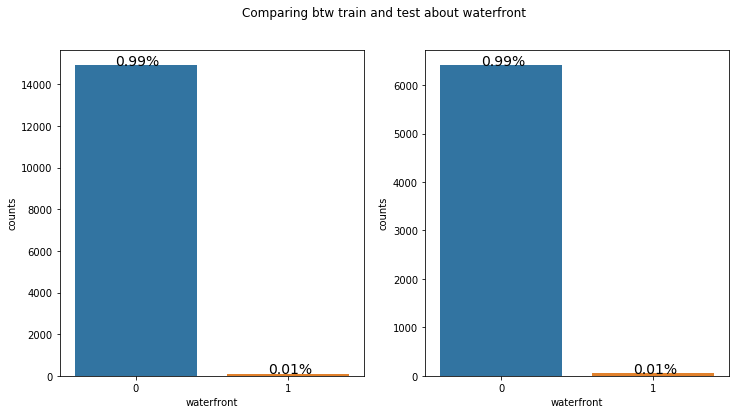

In [26]:
compare_categorical_ratio(waterfront_train,waterfront_test,"waterfront",3)

Waterfront값은 여부를 나타내는 Binary 값이며, 값의 크기는 다르더라도 그 비중은 유사하다는 것을 알아냈습니다.

# View
뷰는 집이 얼마나 좋아보이는 지에 대한 정도인데, 뭘 어떻게 나타냈다는지 모르겠으니까 한번 알아보도록 합시다.

In [27]:
train.view.value_counts().sort_index()

0    13548
1      241
2      665
3      373
4      208
Name: view, dtype: int64

view값은 여러 척도들 중 순서척도를 가지는 컬럼인 것 같습니다. (척도에 대한 설명은 맨 위 Reference를 활용하세요.)단지 이 값만보고는 우리가 다루는 view라는 변수가 0으로 갈수록 좋은지 5로 갈수록 좋은지 파악해야될 것 같습니다. 위의 단계와 동일하게 훈련셋과 테스트셋이 가지는 각 값들에 대한 비중이 유사한지 살펴보려고 합니다.

In [28]:
view_train= make_count_df(train,"view")
view_test = make_count_df(test,"view")

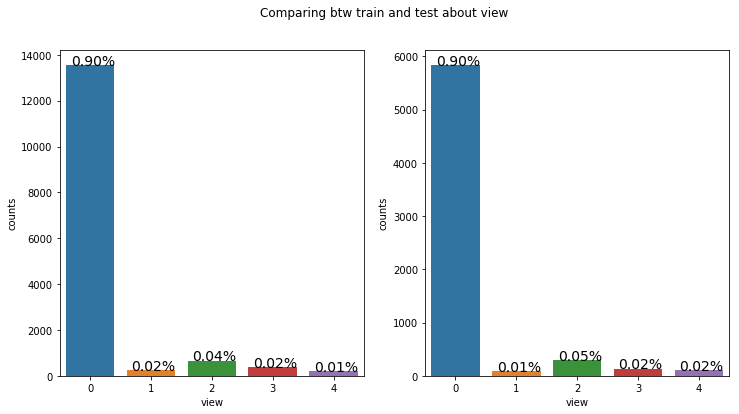

In [29]:
compare_categorical_ratio(view_train,view_test,"view",10)

해당 view값이 클수록 좋은지 작을 수록 좋은지에 대한 것은 나중에 Price와 각 변수들을 비교할 때 알아보도록 합시다.

# Condition
이번 컬럼은 집의 상태를 나타내는 컬럼입니다. 아마도 view와 유사하게 순서척도일 것 같습니다. 높은쪽으로 갈 수록 좋은 상태의 집임이 예상되지만 일단은 훈련세트와 테스트세트의 컨디션 값들에 대한 분포를 알아봅시다.

In [30]:
condition_train = make_count_df(train,"condition")
condition_test = make_count_df(test,"condition")

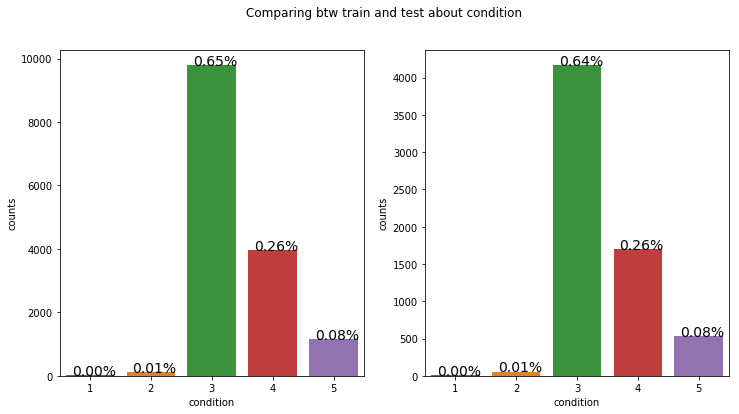

In [31]:
compare_categorical_ratio(condition_train,condition_test,"condition",8)

소숫점을 절삭하였지만 비율이 유사하는 것을 알 수 있습니다. 그리고 3이 중간상태를 의미하는 것같으므로 집의 상태가 보통인 집이 가장 많음을 알 수 있습니다.

# Grade
grade는 King county grade방식이 무엇인지는 모르겠지만 상태를 나타내는 것이라고 합니다. 이 또한 왠지 적은 범위의 값들을 가질 것 같으며 우리가 살펴보았던 Condition과 상관관계가 클것 같습니다. 한번 또 살펴봅시다.

In [32]:
grade_train = make_count_df(train,"grade") 
grade_test = make_count_df(test,"grade")

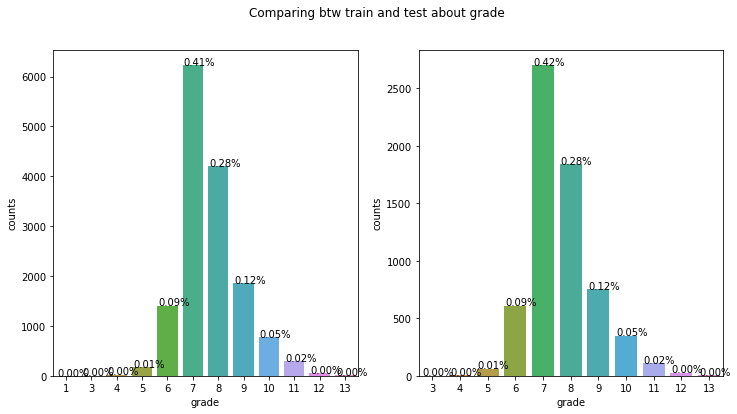

In [33]:
compare_categorical_ratio(grade_train,grade_test,"grade",adjust_x_annotate=20,fontsize=10)

grade 수치도 훈련세트와 테스트셋이 유사하다는 것을 알 수 있습니다. 그런데 훈련세트에는 1이라는 grade가 존재하지만 테스트셋에는 존재하지 않는 것 같습니다. 만약 상황이 이 반대였으면 문제가 생겼겠지만, 그것이 아니기 때문에 문제가 없을 것 같습니다. grade에서는 7,8정도의 수준을 받는 집이 보통 정도의 집 수준이라고 할 수 있을 것 같습니다.

# sqft_above and sqft_basement
위들의 지표는 지하를 제외한 평당면적과 지하실의 평당면적을 나타냅니다. 이는 많은 면적들이 연속하여 분포할 것같기 때문에 kdeplot을 사용하여 분포를 알아볼 것입니다. 그런데 지하실이 없는 집이 있을 수 있는데 이들 집은 어떤 형태로 데이터가 표현될지 살펴보고 그 값을 기준점으로 잡아 지하실이 있는집과 없는집과 같은 Binary형태의 추가적인 속성을 도출할 수 있을 것 같습니다.

Text(0.5, 0.98, 'Distribution of sqft_above and sqft_basement')

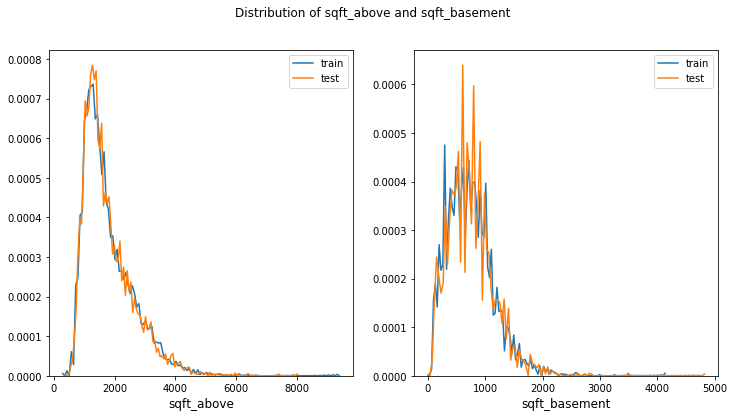

In [34]:
fig,ax = plt.subplots(1,2,figsize=[12,6])

ax1 = plt.subplot(1,2,1)
sns.kdeplot(train.sqft_above,bw=0.5,label="train")
sns.kdeplot(test.sqft_above,bw=0.5,label='test')
ax1.set_xlabel("sqft_above",fontsize=12)

ax2 = plt.subplot(1,2,2)
sns.kdeplot(train.sqft_basement,bw=0.5,label="train")
sns.kdeplot(test.sqft_basement,bw=0.5,label='test')
ax2.set_xlabel("sqft_basement",fontsize=12)

plt.suptitle("Distribution of sqft_above and sqft_basement")

In [35]:
print("Ratio of 0 in sqft_basement of train_set {:.2f}% among {}".format(sum(train.sqft_basement==0)/len(train)*100,len(train)))
print("Ratio of 0 in sqft_basement of test_set {:.2f}% among {}".format(sum(test.sqft_basement==0)/len(test)*100,len(test)))

Ratio of 0 in sqft_basement of train_set 60.81% among 15035
Ratio of 0 in sqft_basement of test_set 60.50% among 6468


sqft_above와 sqft_basement의 분포를 한 번 살펴보았습니다. 그리고 우리가 보았을 때, 지하실을 가지고 있지 않은 집은 전체 데이터셋의 60퍼센트나 차지하고 있었습니다. 이를 통해 우리는 지하실을 가지고 있는지 아닌지를 보여주는 Binary특성을 새로 만들어봅시다.

# yr_bulit and yr_renovate
이 둘은 집을 건축한 년도와 집을 수리한 년도를 나타냅니다. 직관적으로 생각해보면 집이 엄청난 문화유산이 아니라면 오래된 집의 경우에는 가격이 낮을 것같고 집을 수리한 년도가 현재와 가까울 수록 가격은 또 높아질 것 같습니다. 그리고 집을 짓지 않은 집은 없겠지만, 집을 수리하지 않은 집도 있을 것 같기 때문에 지하실과 마찬가지로 추가적으로 논리식값으로도 나타내 보도록 합시다.

Text(0.5, 0.98, 'Distribution of yr_built and yr_renovated')

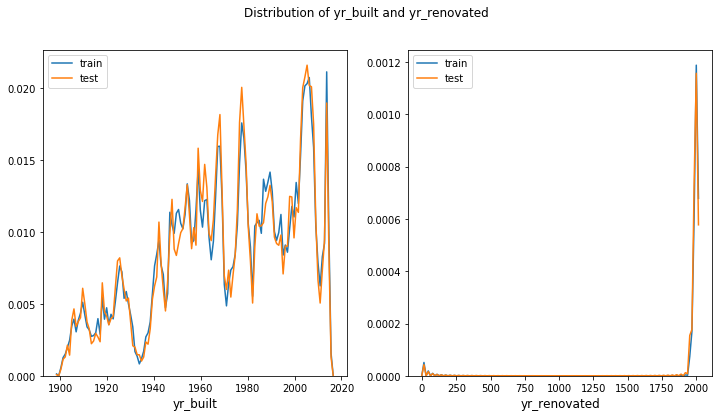

In [36]:
fig,ax = plt.subplots(1,2,figsize=[12,6])

ax1 = plt.subplot(1,2,1)
sns.kdeplot(train.yr_built,bw=0.5,label="train")
sns.kdeplot(test.yr_built,bw=0.5,label='test')
ax1.set_xlabel("yr_built",fontsize=12)

ax2 = plt.subplot(1,2,2)
sns.kdeplot(train.yr_renovated,bw=0.5,label="train")
sns.kdeplot(test.yr_renovated,bw=0.5,label='test')
ax2.set_xlabel("yr_renovated",fontsize=12)

plt.suptitle("Distribution of yr_built and yr_renovated")

일단 집을 지은 건축년도는 훈련셋과 테스트셋이 유사한 분포를 나타냈고, 수리년도는 제가 예측했던 것 처럼 수리하지 않은 집들은 0이라는 년도를 가지기 때문에 kdeplot이 특이한 모양을 가집니다. yr_renovated를 수리하지 않은 집을 제외한 분포를 한 번 살펴보려고합니다.

Text(0.5, 1.0, 'yr_renovated except for 0')

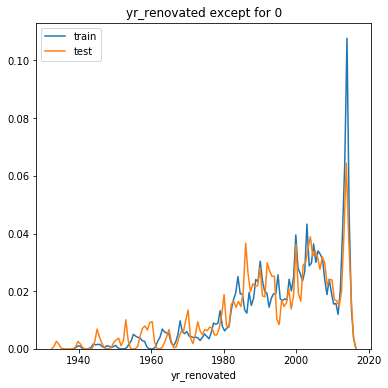

In [37]:
plt.figure(figsize=[6,6])

sns.kdeplot(train.loc[train["yr_renovated"]!= 0,"yr_renovated"],bw=0.5,label="train")
sns.kdeplot(test.loc[test["yr_renovated"]!= 0,"yr_renovated"],bw=0.5,label="test")
plt.xlabel("yr_renovated")
plt.title("yr_renovated except for 0")

수리된 집들을 본다면 최소 1930년도부터 해당 값이 부여가 되고 있다는 것을 알 수 있습니다. 따라서 우리가 sqft_basement에 실행했던 것과 같이 수리여부를 논리형 값으로 나타내는 컬럼을 만들어 줍시다.

In [38]:
print("Ratio of 0 in yr_renovated of train_set {:.2f}% among {}".format(sum(train.yr_renovated==0)/len(train)*100,len(train)))
print("Ratio of 0 in yr_renovated of test_set {:.2f}% among {}".format(sum(test.yr_renovated==0)/len(test)*100,len(test)))

Ratio of 0 in yr_renovated of train_set 95.80% among 15035
Ratio of 0 in yr_renovated of test_set 95.64% among 6468


# zipcode
zipcode는 우편번호를 나타냅니다. 주변을 둘러보면 같은 동네에서도 부촌과 빈촌이 존재하듯이 우편번호를 이용하게 되면 이 둘을 구분할 수 있어 우리가 집값을 예측하는데 도움이 될 것 같습니다. 그렇다면 zipcode의 값을 살펴보고 어떻게 처리할 것인지 생각해 봅시다.

In [39]:
train.zipcode.head()

0    98178
1    98028
2    98074
3    98003
4    98198
Name: zipcode, dtype: int64

우편번호는 뭔가 숫자로 이루어지는 것 같습니다. 그런데 우편번호가 없거나, 우편번호가 숫자가 아닌 어느 다른 값들로 구성될 수 있습니다. 그렇다면 일반적인 우편번호의 형태인 다섯개의 숫자를 따르지 않는 예외의 것들을 살펴봅시다.

In [40]:
str(train.zipcode[0])

'98178'

In [41]:
import re

re1='(\\d{5})'
rg = re.compile(re1)

dummy_train = train.zipcode.apply(lambda x :rg.search(str(x)))
dummy_test = test.zipcode.apply(lambda x :rg.search(str(x)))

In [42]:
print("The number of unexpected form about zipcode of train_set {}".format(sum(dummy_train == 0)))
print("The number of unexpected form about zipcode of test_set {}".format(sum(dummy_test == 0)))

The number of unexpected form about zipcode of train_set 0
The number of unexpected form about zipcode of test_set 0


우리는 바로 zipcode를 우리의 분석에 사용할 수 있을 것 같습니다. 왜냐하면 간단한 정규표현식을 사용하여 검토해 보았을 때 우리가 정해둔 5개의 연속된 우편번호를 따르지 않는 것은 없다는 것을 알아냈기 때문입니다. 

# lat and lon
위의 두 지표는 위도와 경도를 나타냅니다. 물론 이미 제 생각으로는 우편번호와 위도와 경도는 굉장히 밀접한 관련이 있을 것이라고 생각됩니다. 그렇다면 위도와 경도를 산포도를 이용해서 간단하게 위치를 찍어보도록 합시다.

Text(0.5, 1.0, 'Distribution of lat and long about train and test set')

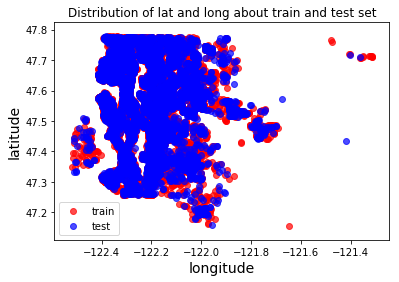

In [43]:
plt.scatter(x=train.long,y=train.lat,color='red',label='train',alpha=0.7)
plt.scatter(x=test.long,y=test.lat,color='blue',label='test',alpha=0.7)
plt.legend()
plt.xlabel("longitude",fontsize=14)
plt.ylabel("latitude",fontsize=14)
plt.title("Distribution of lat and long about train and test set")

Text(0.5, 0.98, 'Longitude and Latitude Distribution of train_set')

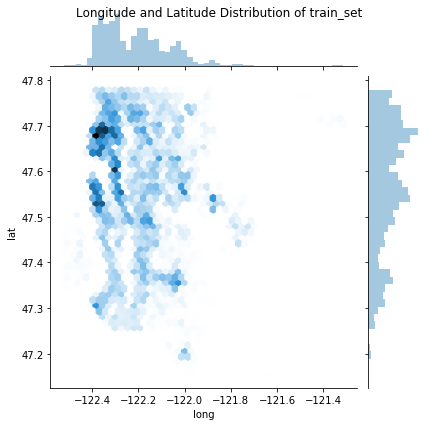

In [44]:
sns.jointplot(x='long',y='lat',data=train,kind="hex")
plt.suptitle("Longitude and Latitude Distribution of train_set")

Text(0.5, 0.98, 'Longitude and Latitude Distribution of test_set')

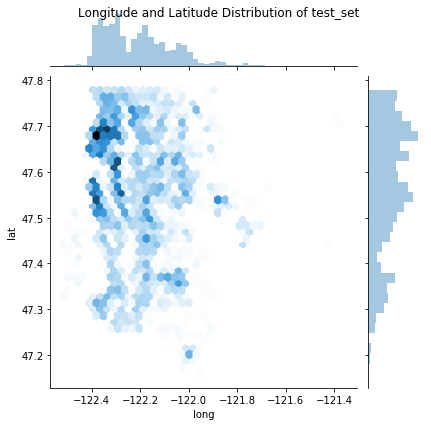

In [45]:
sns.jointplot(x='long',y='lat',data=test,kind="hex")
plt.suptitle("Longitude and Latitude Distribution of test_set")

위도와 경도의 분포는 훈련셋과 테스트셋이 유사하다는 것을 알 수 있었습니다. 그리고 두 데이터 셋을 개별적으로 보았을 때 어느 특정 영역에 집의 수가 많은 것 같다는 것을 알 수 있습니다.

## <a id='32'>타겟 변수와 각 데이터와의 관계</a>  

이제 우리는 타겟 변수인 Price 와 개별 컬럼들에 대해서 이야기 해 볼것입니다.

일단 우리가 가진 date에서 T이하의 내용은 시분초를 나타내는 것 같은데 모두 같은 값을 가지고 있으므로 우리가 유용하다고 판단되는 년,월,일 형태로 가공하여 사용하겠습니다.

# Date

In [46]:
def decomposition_date(df):
    dummy = df.copy()
    
    dummy["date"] = pd.to_datetime(dummy["date"])
    
    dummy["year"] = dummy.date.apply(lambda x: str(x).split("-")[0]).astype('int')
    dummy["month"] = dummy.date.apply(lambda x:str(x).split("-")[1]).astype('int')
    dummy["day"] = dummy.date.apply(lambda x:str(x).split("-")[-1]).apply(lambda x:x.split(" ")[0]).astype('int')
    
    return dummy

In [47]:
decom_train = decomposition_date(train)
decom_test = decomposition_date(test)

In [48]:
decom_train.groupby('year')['price'].agg(['mean','median'])

,mean,median
year,,
2014,538642.369733,450000.0
2015,545025.153974,454675.0


Text(0.5, 1.0, 'Mean and Median by Day')

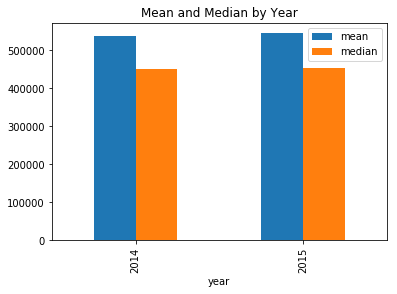

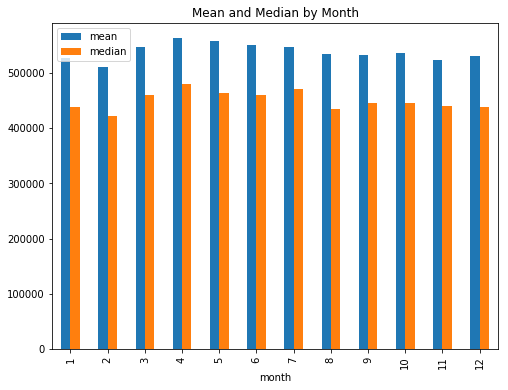

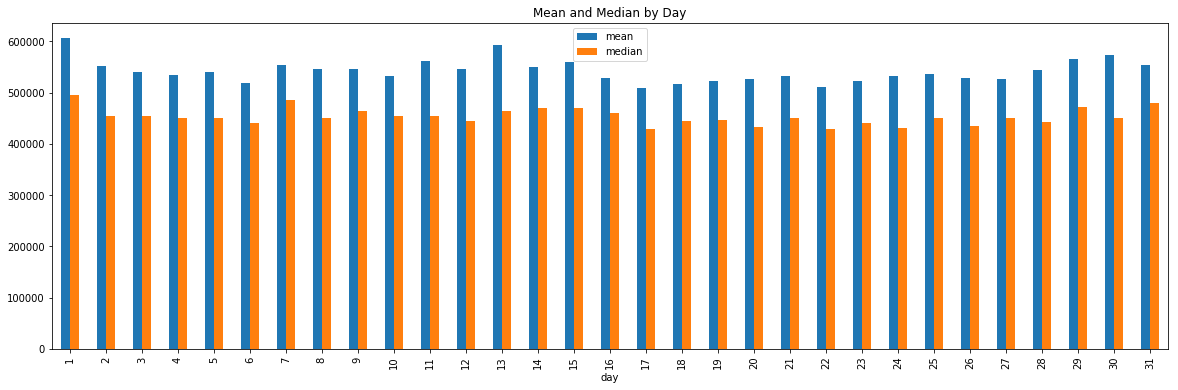

In [49]:
decom_train.groupby('year')['price'].agg(['mean','median']).plot(kind='bar',linewidth=2)
plt.title("Mean and Median by Year")

decom_train.groupby('month')['price'].agg(['mean','median']).plot(kind='bar',linewidth=1,figsize=[8,6])
plt.title("Mean and Median by Month")

decom_train.groupby('day')['price'].agg(['mean','median']).plot(kind='bar',linewidth=1,figsize=[20,6])
plt.title("Mean and Median by Day")

년도/월/일을 구분하였을 때,
* 년도별로는 2015년이 미세한 차이로 가격이 더 높았고
* 월 별로는 3,4,5월에 집값이 비싼시기이며
* 일 별로는 1일과 13일에 왠지 모르겠지만 가격이 높다는 것을 알 수 있다.

# Bedrooms

Text(0, 0.5, 'Price')

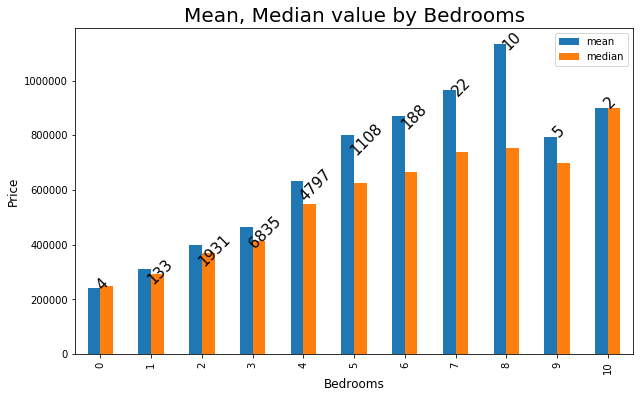

In [50]:
ax = decom_train.groupby('bedrooms')['price'].agg(['mean','median']).plot(kind='bar',linewidth=2,figsize=[10,6])

for i,p in enumerate(ax.patches):
    if i < 11:
        ax.annotate(decom_train.bedrooms.value_counts().sort_index()[i],(p.get_x()+p.get_width()*0.5, p.get_y()+p.get_height()*1.01),fontsize=15,rotation=45)

plt.title("Mean, Median value by Bedrooms",fontsize=20)
plt.xlabel("Bedrooms",fontsize=12)
plt.ylabel("Price",fontsize=12)

일단 침실의 수는 8개를 경과하기까지는 증가하지만 9개나 10개의 경우에는 갑자기 감소한다 이 두 경우의 표본의 수가 적기 때문이다.

# Bathrooms

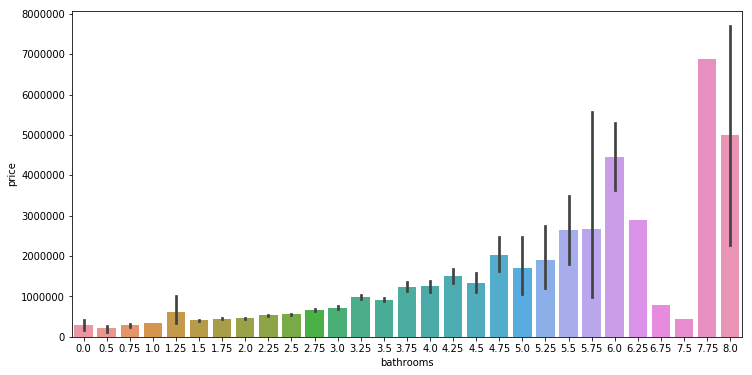

In [51]:
plt.figure(figsize=[12,6])
sns.barplot(x='bathrooms',y='price',data=decom_train)

# sqft_living

In [52]:
def float_with_price(xlabel,df):
    fig,ax = plt.subplots(1,2,figsize=[14,6])

    ax1 = plt.subplot(1,2,1)
    sns.scatterplot(x=xlabel,y='price',data=df,ci=0.95)
    ax1.set_title(f"Scatterplot about {xlabel} with price",fontsize=14)
    ax2 = plt.subplot(1,2,2)
    sns.regplot(x=xlabel,y='price',data=df,ci=0.95)
    ax2.set_title(f"Regplot about {xlabel} with price",fontsize=14)
    plt.xticks(rotation=60)
    plt.suptitle(f"Relationship about {xlabel} with price",fontsize=20)

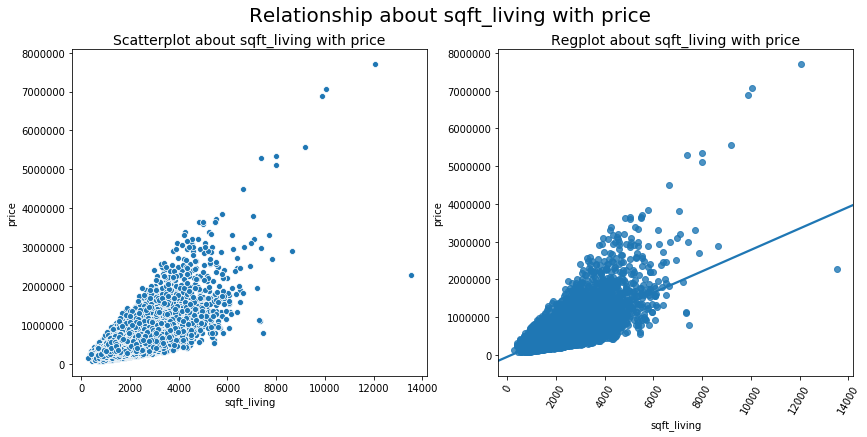

In [53]:
float_with_price("sqft_living",train)

# sqft_lot

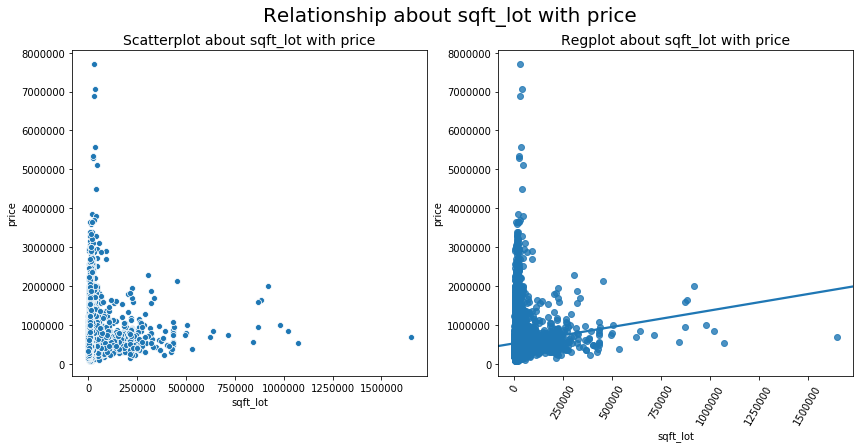

In [54]:
float_with_price("sqft_lot",train)

# floors

In [55]:
def ordinal_with_price(xlabel,df,rotation=0):
    
    fig,ax = plt.subplots(1,2,figsize=[14,6])

    ax1 = plt.subplot(1,2,1)
    sns.barplot(x=xlabel,y="price",data=train)
    ax1.set_xlabel(xlabel,fontsize=12)
    ax1.set_ylabel("price",fontsize=12)
    ax1.set_title(f"Barplot about {xlabel} with price",fontsize=18)
    
    for i,p in enumerate(ax1.patches):

        ax1.annotate(s=train[xlabel].value_counts().sort_index().values[i],xy= (p.get_x()+p.get_width()/len(train[xlabel].value_counts()), p.get_height()*1.05),fontsize=15,rotation=rotation)
        
    ax2 = plt.subplot(1,2,2)
    sns.boxplot(x=xlabel,y='price',data=train)
    ax2.set_xlabel(xlabel,fontsize=12)
    ax2.set_ylabel("price",fontsize=12)
    ax2.set_title(f"Boxplot about {xlabel} with price",fontsize=18)
    
    plt.suptitle(f"Relationship about {xlabel} with price",fontsize=20)

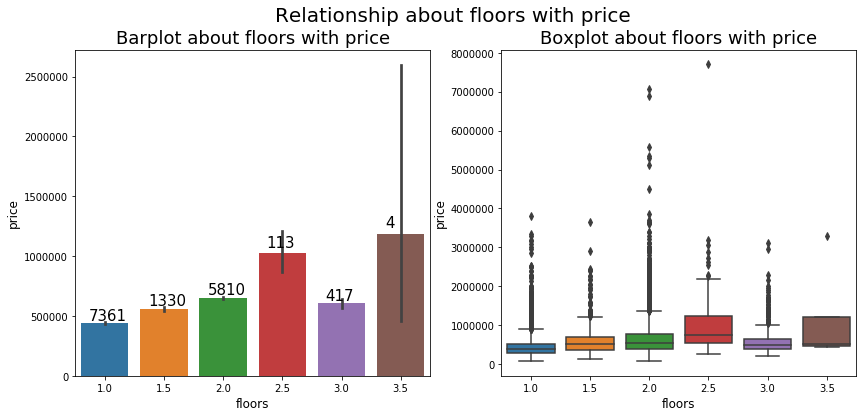

In [56]:
ordinal_with_price("floors",train)

# Waterfront

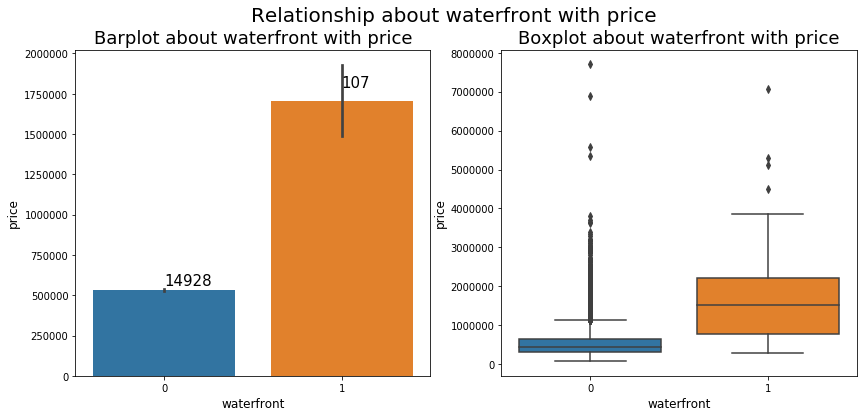

In [57]:
ordinal_with_price("waterfront",train)

# View

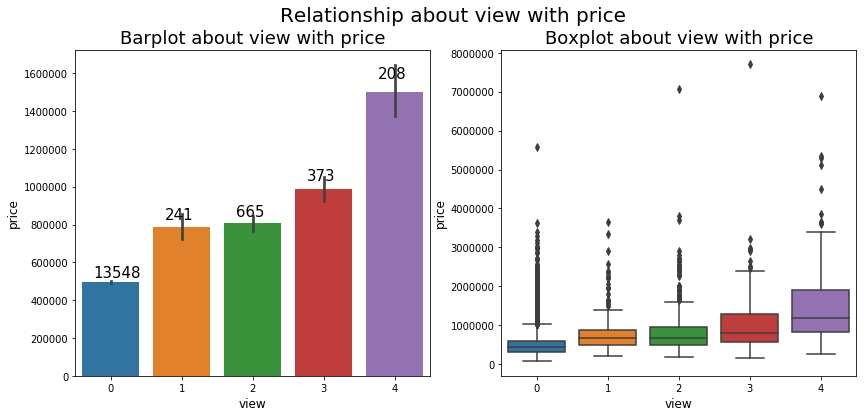

In [58]:
ordinal_with_price("view",train)

# condition

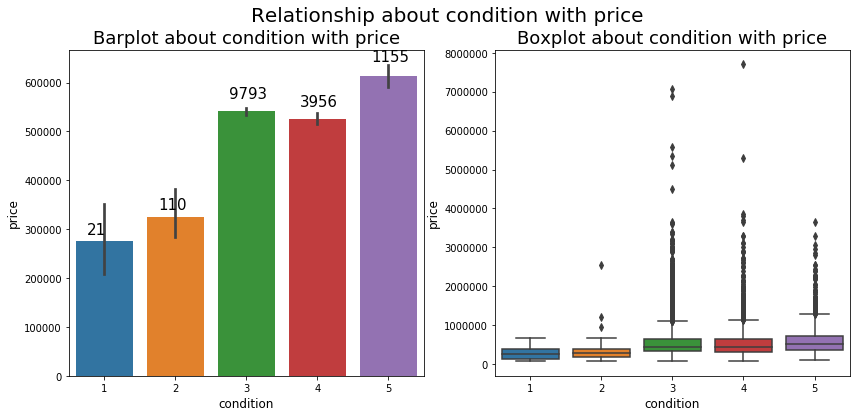

In [59]:
ordinal_with_price("condition",train)

# Grade

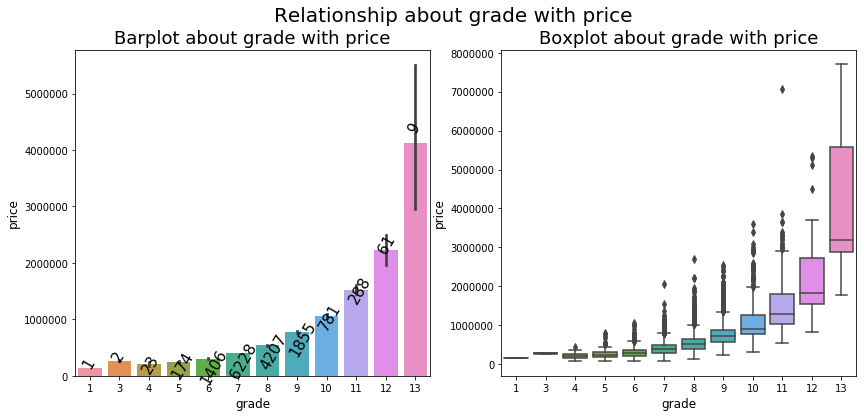

In [60]:
ordinal_with_price("grade",train,rotation=60)

# sqft_above

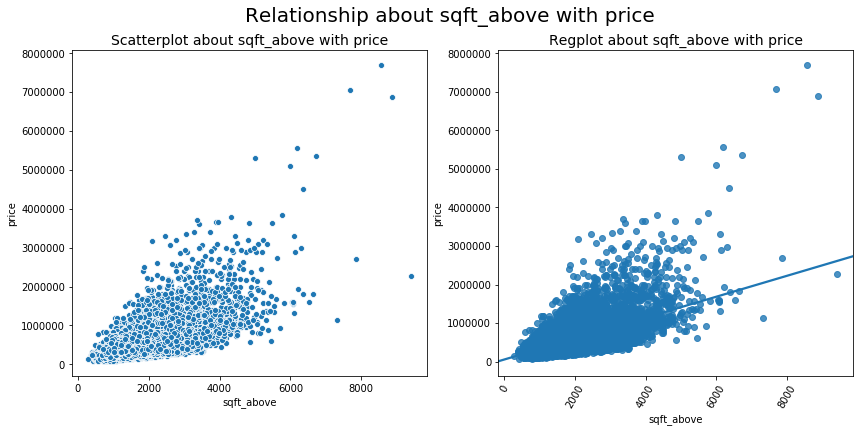

In [61]:
float_with_price("sqft_above",train)

# sqft_basement

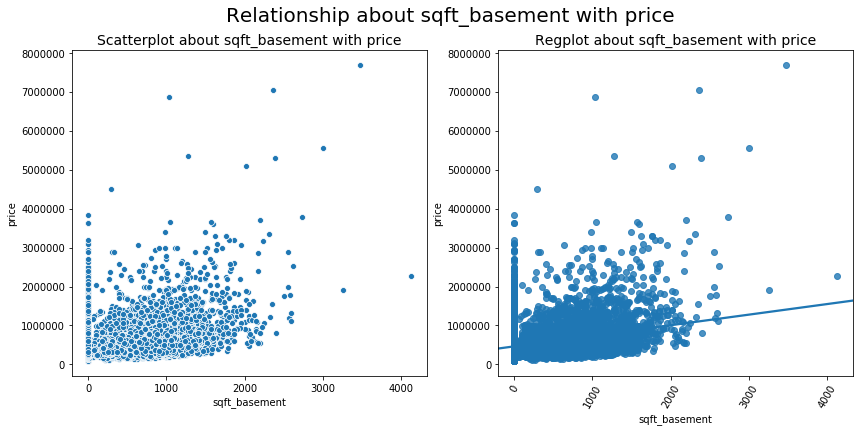

In [62]:
float_with_price("sqft_basement",train)

# yr_built

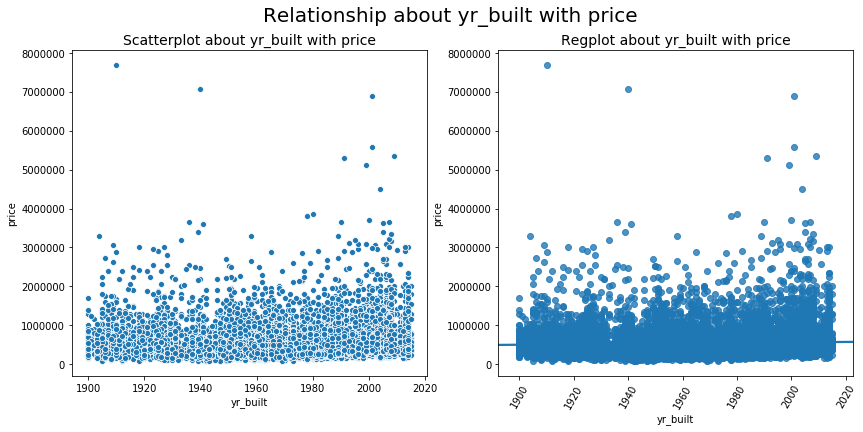

In [63]:
float_with_price("yr_built",train)

# yr_renovated

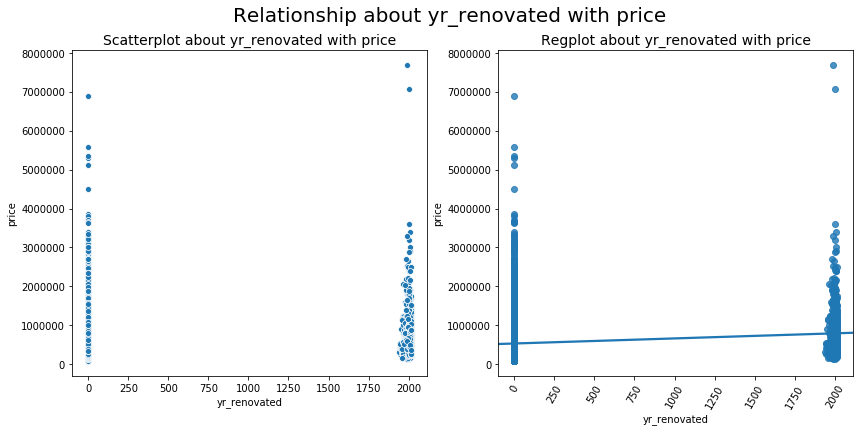

In [64]:
float_with_price("yr_renovated",train)

# sqft_living15

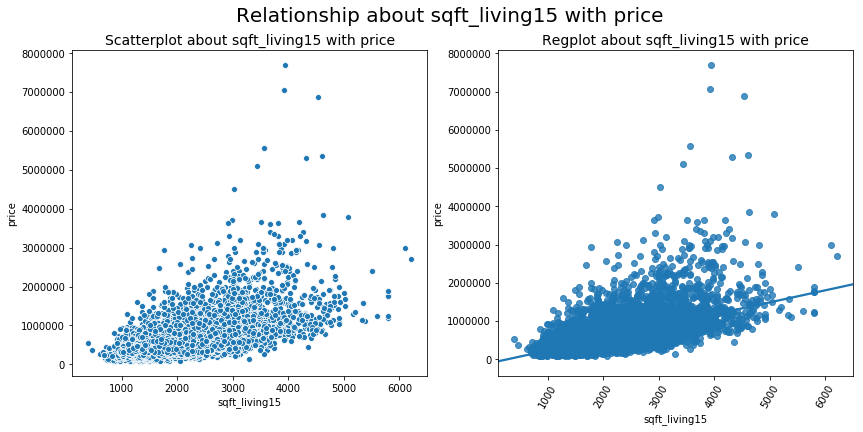

In [65]:
float_with_price("sqft_living15",train)

# sqft_lot15

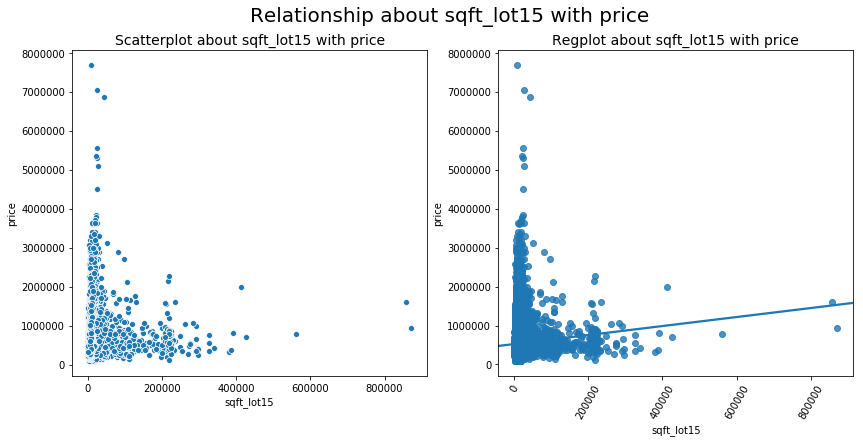

In [66]:
float_with_price("sqft_lot15",train)

# <a id='4'>Feature Engineering</a>
우리는 상관관계를 살펴보았는데, 우리가 가진 컬럼들을 더 조합해서 목표값을 더 잘 예측할 수 있는 지표들을 만들어보도록 합시다. <br />
Feature Engineering에 대한 참고 kernel은 아래의 두 개입니다.
> House Price Prediction EDA (updated 2019.03.12) <br />
> https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12 <br />
> XGBoost, Lightgbm ( catboost 예정 ) <br />
> https://www.kaggle.com/marchen911/xgboost-lightgbm

제가 공부하고 있는 파이썬 머신러닝 완벽가이드에 따르면 우리가 예측해야하는 target값이던 column으로 이용하게될 feature던 한 쪽으로 치우친 분포를 보이고 있는 경우에는 **로그화를 이용하여 예측하고 타겟의 경우에는 이를 다시 지수화하여 복구시키는 것**이 좋다고 언급하였습니다. 따라서 우리는 우리의 target값인 price를 로그화하며, 우리가 살펴본 컬럼들 중 분포가 치우친 분포를 가지고 있는 경우에는 로그화 해주었습니다.

> 파이썬 머신러닝 완벽 가이드 <br />
> http://www.yes24.com/Product/Goods/69752484?Acode=101

In [67]:
skewed_cols = ["bedrooms","sqft_living","sqft_lot","sqft_above","sqft_basement","sqft_living15","sqft_lot15"]

치우친 컬럼들을 로그화합니다.

In [68]:
def to_logarithm(df,cols):
    
    result_df = df.copy()
    
    for col in cols:
        result_df[col] = np.log1p(result_df[col])
        
    return result_df

In [69]:
log_train = to_logarithm(train,skewed_cols)
log_test = to_logarithm(test,skewed_cols)

아래의 함수는 추가적인 컬럼들을 만드는 함수입니다. 해당 컬럼들은 위에서 참조한 커널들에서 가져왔습니다. <br />

## **여기서 굉장한 교훈 [데이터전처리]**

파이썬 머신러닝 완벽가이드에도 있었지만 Garbage in, Garbage out이라고 좋지못 한 컬럼들을 투입해서 학습한 모델은 올바른 예측값을 낼 수가 없다는 것을 깨달았습니다. 다음 컴피티션이나 추후에 할 때에는 하나의 좋은 성능을 나타내는 모델로 피처들을 추가해보면서 점수의 등락을 비교해가며 적절한 피처를 도출하고 학습에 투입하는 즉, 데이터 전처리의 중요성이 엄청나다는 것을 깨달았습니다. 

In [70]:
def making_additional_cols(df):
    
    result_df = df.copy()
    
    result_df['date'] = result_df['date'].apply(lambda e: e.split('T')[0])
    result_df['yr_renovated'] = result_df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    result_df['renovated'] = result_df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    result_df['yr_renovated'] = result_df['yr_renovated'].fillna(result_df['yr_built'])
    result_df['renovated'] = result_df['renovated'].fillna(0)
    result_df['yr_renovated'] = result_df['yr_renovated'].astype('int')
    
    result_df.loc[result_df.renovated > 0,'renovated']= 1.0
    
    result_df['total_rooms'] = result_df['bedrooms'] + result_df['bathrooms']
    result_df['sqft_ratio'] = result_df['sqft_living'] / result_df['sqft_lot']
    result_df['sqft_total_size'] = result_df['sqft_above'] + result_df['sqft_basement']
    result_df['sqft_ratio_1'] = result_df['sqft_living'] / result_df['sqft_total_size']
    result_df['sqft_ratio15'] = result_df['sqft_living15'] / result_df['sqft_lot15']
    
    result_df["year"] = pd.to_numeric(result_df.date.apply(lambda x:x[:4]))
    result_df["month"] = pd.to_numeric(result_df.date.apply(lambda x:x[4:6]))
    result_df.drop("date",axis=1,inplace=True)
    
    return result_df

In [71]:
adj_log_train = making_additional_cols(log_train)
adj_log_test = making_additional_cols(log_test)

In [72]:
adj_log_train.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,year,month
0,0,221900.0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955,98178,47.5112,-122.257,7.201171,8.639588,0.0,2.386294,0.818803,7.074117,1.0,0.833509,2014,10
1,1,180000.0,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933,98028,47.7379,-122.233,7.908755,8.995041,0.0,2.098612,0.721756,6.647688,1.0,0.879235,2015,2
2,2,510000.0,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987,98074,47.6168,-122.045,7.496097,8.923191,0.0,3.386294,0.825489,7.427144,1.0,0.840069,2015,2
3,3,257500.0,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995,98003,47.3097,-122.327,7.713785,8.827615,0.0,3.636294,0.843688,7.447751,1.0,0.873824,2014,6
4,4,291850.0,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963,98198,47.4095,-122.315,7.409136,9.181118,0.0,2.886294,0.758837,6.966967,1.0,0.806997,2015,1


In [73]:
adj_log_train.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,year,month
0,0,221900.0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955,98178,47.5112,-122.257,7.201171,8.639588,0.0,2.386294,0.818803,7.074117,1.0,0.833509,2014,10
1,1,180000.0,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933,98028,47.7379,-122.233,7.908755,8.995041,0.0,2.098612,0.721756,6.647688,1.0,0.879235,2015,2
2,2,510000.0,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987,98074,47.6168,-122.045,7.496097,8.923191,0.0,3.386294,0.825489,7.427144,1.0,0.840069,2015,2
3,3,257500.0,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995,98003,47.3097,-122.327,7.713785,8.827615,0.0,3.636294,0.843688,7.447751,1.0,0.873824,2014,6
4,4,291850.0,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963,98198,47.4095,-122.315,7.409136,9.181118,0.0,2.886294,0.758837,6.966967,1.0,0.806997,2015,1


마지막으로 우리의 target값인 price를 log1p를 통해서 로그화합니다. 그냥 log를 하지않고 log1p를 하는 이유는 만약에 price하는 값이 0이 있는 경우에는 log0을 하게되면 값이 나오지 않기 때문에 이를 위해서 target값에 1을 더하고 로그화 하는 log1p를 사용했다. 그리고 이를 복원하는데 있어서 그냥 np.exp가 아닌 np.expm1을 활용해야 한다고 한다.

In [74]:
adj_log_train["price"] = np.log1p(adj_log_train["price"])

# <a id='5'>Modeling</a>
모델링에 있어서 우리는 제목에서 알 수 있듯이 xgboost 모델과 lightgbm모델을 앙상블 할 것입니다. 왜냐하면 두 모델은 각각의 모델의 결과를 이끌어낸 feature_importance를 시각화했을 때 중요시여겨지는 컬럼들의 특징이 다르기 때문입니다. 서로 다른 모델을 앙상블을 통해 좋은 모델을 이번 모델링 단계에서 도출해볼 것입니다.

1. XGBoost에서는 fold수를 5와 10으로 구분하여 stacking을 할 것입니다.
2. LightGBM에서는 XGBoost에서와 동일하게 fold별로 stacking하며, 거기에 추가적으로 seed를 다르게 한 모델들을 만들어 내고 그 결과를 다중으로 쌓아서 도출해보겠습니다.

XGBoost상에서는 다중으로 쌓지 않는 이유는 너무 시간이 오래걸릴 뿐더러, 좋은 성능을 도출해내지 못했기 때문입니다. 마지막으로 각각의 모델의 성능을 그림으로 그려보고 그들중에 좋은 XGBoost와 LighGBM을 골라서 0.5씩 앙상블 해볼 것입니다.

그리고 아래의 함수를 만드는데 있어서 아래의 공식안내사이트의 API안내문서를 활용했습니다.
> 참고 <br />
> https://xgboost.readthedocs.io/en/latest/python/python_api.html <br />
> https://lightgbm.readthedocs.io/en/latest/Python-API.html <br />

추가적으로 Boosting 알고리즘의 이해를 도와준 좋은 사이트들도 아래에 링크남깁니다.
> https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/ <br />
> https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ <br />


In [75]:
X_adj_log_train = adj_log_train[adj_log_train.columns.values[2:]]
y_adj_log_train = adj_log_train["price"]
X_adj_log_test = adj_log_test[adj_log_test.columns.values[1:]]

In [76]:
predictions_dict = dict()
scores_dict = dict()

## <a id='51'>XGBRegressor</a>  


아래의 코드는 fold별로 stacking을 다르게 하는 XGBoost모델을 사용하기 위한 함수입니다. <br />
(사실 아래의 코드에서 xgb_rmse는 타겟값인 price를 로그화하기로 한 이후에는 사용하지 않는 평가함수입니다. 그러나 logarithm을 False로 하고 타겟값을 로그화 하지않은 값을 넘겨준다면 사용될 것입니다.)

In [77]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import mean_squared_error

# price를 로그화 하기 전에 사용했던 xgboost평가 함수
def xgb_rmse(preds,dtrain):
    
    labels = dtrain.get_label()
    
    score = np.sqrt(mean_squared_error(labels,preds))
  
    return "xgb_rmse",score

# 로그화된 price를 사용하는 xgboost평가 함수
def log_xgb_rmse(preds,dtrain):
    
    labels = dtrain.get_label()
    
    score = np.sqrt(mean_squared_error(np.expm1(labels),np.expm1(preds)))
  
    return "xgb_rmse",score

# xgboost 실행 함수
def model_xgb(X_train,y_train,X_test,nfolds=5,hyperparameters=None,logarithm=False):
    
    feature_names = X_train.columns.values
    
    valid_scores = np.zeros(len(X_train))
    predictions = np.zeros(len(X_test))
    
    valid_scores_list = []
    
    importances = np.zeros(len(feature_names))
    
    feature_importance_df = pd.DataFrame()
    feature_importance_df["features"] = feature_names
    
    if hyperparameters:
        params = hyperparameters
      
    else:
        params = {
            'base_score': 0.5,
             'booster': 'gbtree',
             'colsample_bylevel': 1,
             'colsample_bytree': 1,
             'gamma': 0,
             'importance_type': 'gain',
             'learning_rate': 0.1,
             'max_delta_step': 0,
             'max_depth': 3,
             'min_child_weight': 1,
             'missing': None,
             'n_estimators': 100,
             'n_jobs': 1,
             'nthread': None,
             'objective': 'reg:linear',
             'random_state': 101,
             'reg_alpha': 0,
             'reg_lambda': 1,
             'scale_pos_weight': 1,
             'seed': None,
             'silent': True,
             'subsample': 1}
    
    xgbr = xgb.XGBRegressor(**params)
    
    if logarithm:
        fold = KFold(n_splits=nfolds,shuffle=True,random_state=12)
        e_metric = log_xgb_rmse
    else:
        fold = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=12)
        e_metric = xgb_rmse
    
    print(params)
    
    for i,(train_indices,valid_indices) in enumerate(fold.split(X_train.values,y_train.values)):
        
        X = X_train.loc[train_indices]
        y = y_train.loc[train_indices]
        X_valid = X_train.loc[valid_indices]
        y_valid = y_train.loc[valid_indices]
        
        print("{} fold processing".format(i+1),"#"*20)
        
        xgbr.fit(X,y,eval_metric=log_xgb_rmse,verbose=500,early_stopping_rounds=250,eval_set=[(X,y),(X_valid,y_valid)])
  
        valid_scores_list.append(xgbr.get_booster().best_score)
        
        feature_importance_df[f"{i+1}"] = xgbr.feature_importances_
        
        if logarithm:
            valid_score = np.expm1(xgbr.predict(X_valid))
            prediction = np.expm1(xgbr.predict(X_test))
        
        else:
            valid_score = xgbr.predict(X_valid)
            prediction = xgbr.predict(X_test)
        
        valid_scores[valid_indices] += valid_score
        predictions += prediction / nfolds
    
    valid_mean_score = np.mean(valid_scores_list)
    
    print(f"mean_valid_score is {valid_mean_score} at {nfolds}")
    
    feature_importance_df["mean"] = feature_importance_df[feature_importance_df.columns.values[1:]].mean(axis=1)
    feature_importance_df["std"] = feature_importance_df[feature_importance_df.columns.values[1:]].mean(axis=1)
    
    fi_sorted = feature_importance_df.sort_values("mean",ascending=False)
    
    plt.figure(figsize=[6,40])
    sns.barplot(x="mean",y="features",data=fi_sorted,xerr=fi_sorted["std"])
    plt.title("Feature Importances of xgboost",fontsize=12)
    plt.show()
        
        
    return valid_mean_score, predictions


Hyperopt를 활용한 Baysian optimization으로 얻어낸 튜닝된 하이퍼 파라미터.

하지만 Hyperparameter 튜닝은 가장 마지막에 최후의 성능을 쥐어짜기 위해서 사용하는 것을 권장합니다. 아무리 파라미터튜닝을 많이 반복하더라도 데이터 전처리를 통해 얻은 모델에 투입할 값들이 좋지 못하다면, 올바르지 못한 결과를 도출할 것이기 때문입니다! 꼭 바람직한 데이터를 얻어낸 뒤에 쥐어짜내는 목적으로만 사용하시길 바랍니다. 튜닝방법은 해당 컴피티션에 다른분들이 해놓으신 걸 보시길 바랍니다.

In [78]:
tuned_params = {
    'alpha': 0.23381888633529596,
    'booster': 'gbtree',
    'colsample_bytree': 0.5833187080443007,
    'gamma': 0.11877149186475625,
    'lambda': 0.7815712086648032,
    'learning_rate': 0.060873580474025094,
    'max_depth': 7,
    'min_child_weight': 5,
    'n_estimators': 3000, #1046
    'objective': 'reg:linear',
    'random_state': 101,
    'subsample': 0.6307967933325185}

Stacking하는 폴드수를 5개로 했을 때 xgboost의 활용

{'alpha': 0.23381888633529596, 'booster': 'gbtree', 'colsample_bytree': 0.5833187080443007, 'gamma': 0.11877149186475625, 'lambda': 0.7815712086648032, 'learning_rate': 0.060873580474025094, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 3000, 'objective': 'reg:linear', 'random_state': 101, 'subsample': 0.6307967933325185}
1 fold processing ####################
[0]	validation_0-rmse:11.795	validation_1-rmse:11.7997	validation_0-xgb_rmse:653621	validation_1-xgb_rmse:665508
Multiple eval metrics have been passed: 'validation_1-xgb_rmse' will be used for early stopping.

Will train until validation_1-xgb_rmse hasn't improved in 250 rounds.
[500]	validation_0-rmse:0.108909	validation_1-rmse:0.160306	validation_0-xgb_rmse:70671	validation_1-xgb_rmse:108830
[1000]	validation_0-rmse:0.101011	validation_1-rmse:0.159603	validation_0-xgb_rmse:65048.9	validation_1-xgb_rmse:107878
Stopping. Best iteration:
[1143]	validation_0-rmse:0.099955	validation_1-rmse:0.159387	validation_0-xgb_rmse:6

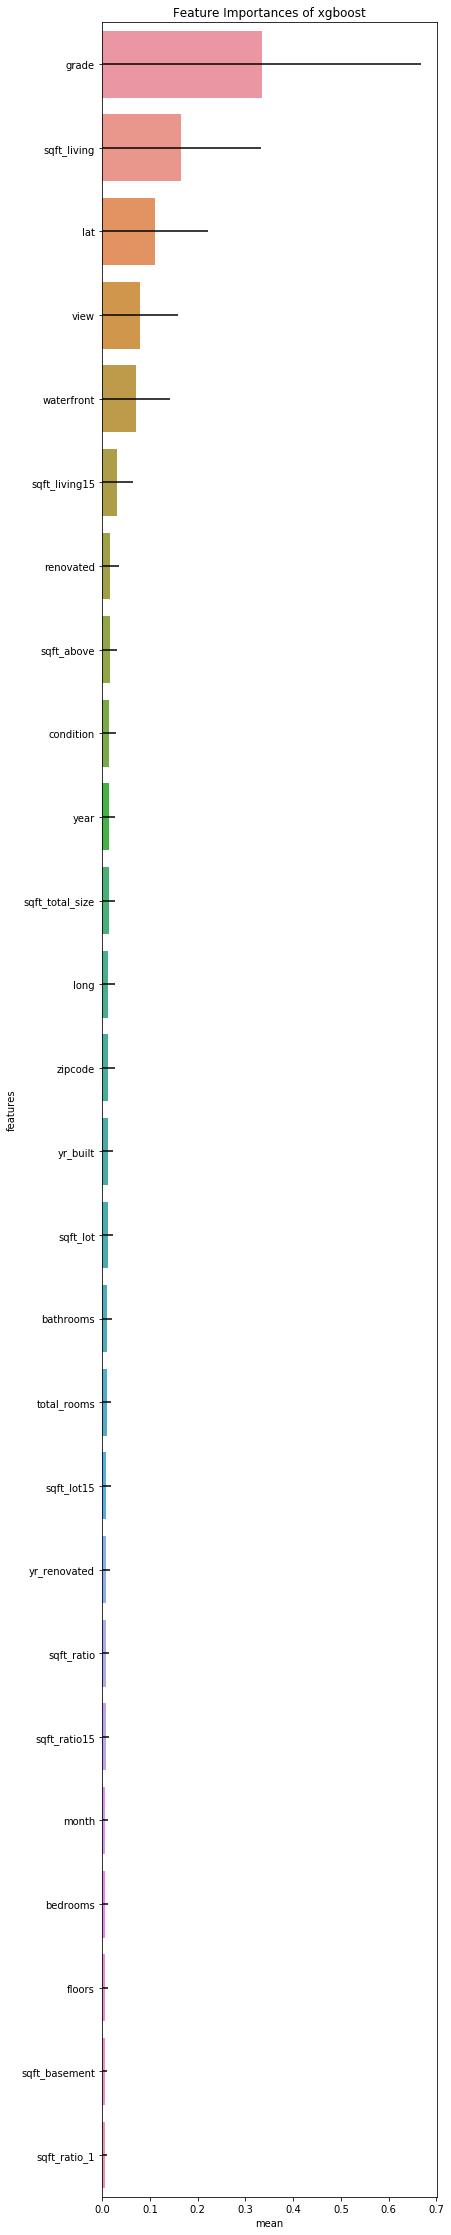

In [79]:
valid_score,predictions = model_xgb(X_train=X_adj_log_train,X_test=X_adj_log_test,y_train=y_adj_log_train,hyperparameters=tuned_params,logarithm=True)

In [80]:
target = "xgb_uni_5"
scores_dict[target] = valid_score
predictions_dict[target] = predictions

In [81]:
submission = pd.read_csv(PATH+"sample_submission.csv")
submission["price"] = predictions
submission.to_csv("xgb_uni_layer_5.csv",index=False)

Stacking하는 폴드수를 10개로 했을 때 xgboost의 활용

{'alpha': 0.23381888633529596, 'booster': 'gbtree', 'colsample_bytree': 0.5833187080443007, 'gamma': 0.11877149186475625, 'lambda': 0.7815712086648032, 'learning_rate': 0.060873580474025094, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 3000, 'objective': 'reg:linear', 'random_state': 101, 'subsample': 0.6307967933325185}
1 fold processing ####################
[0]	validation_0-rmse:11.7941	validation_1-rmse:11.8126	validation_0-xgb_rmse:652687	validation_1-xgb_rmse:685232
Multiple eval metrics have been passed: 'validation_1-xgb_rmse' will be used for early stopping.

Will train until validation_1-xgb_rmse hasn't improved in 250 rounds.
[500]	validation_0-rmse:0.110299	validation_1-rmse:0.165309	validation_0-xgb_rmse:71789.2	validation_1-xgb_rmse:112841
[1000]	validation_0-rmse:0.102116	validation_1-rmse:0.16497	validation_0-xgb_rmse:66407.1	validation_1-xgb_rmse:111002
Stopping. Best iteration:
[932]	validation_0-rmse:0.102905	validation_1-rmse:0.164913	validation_0-xgb_rmse:

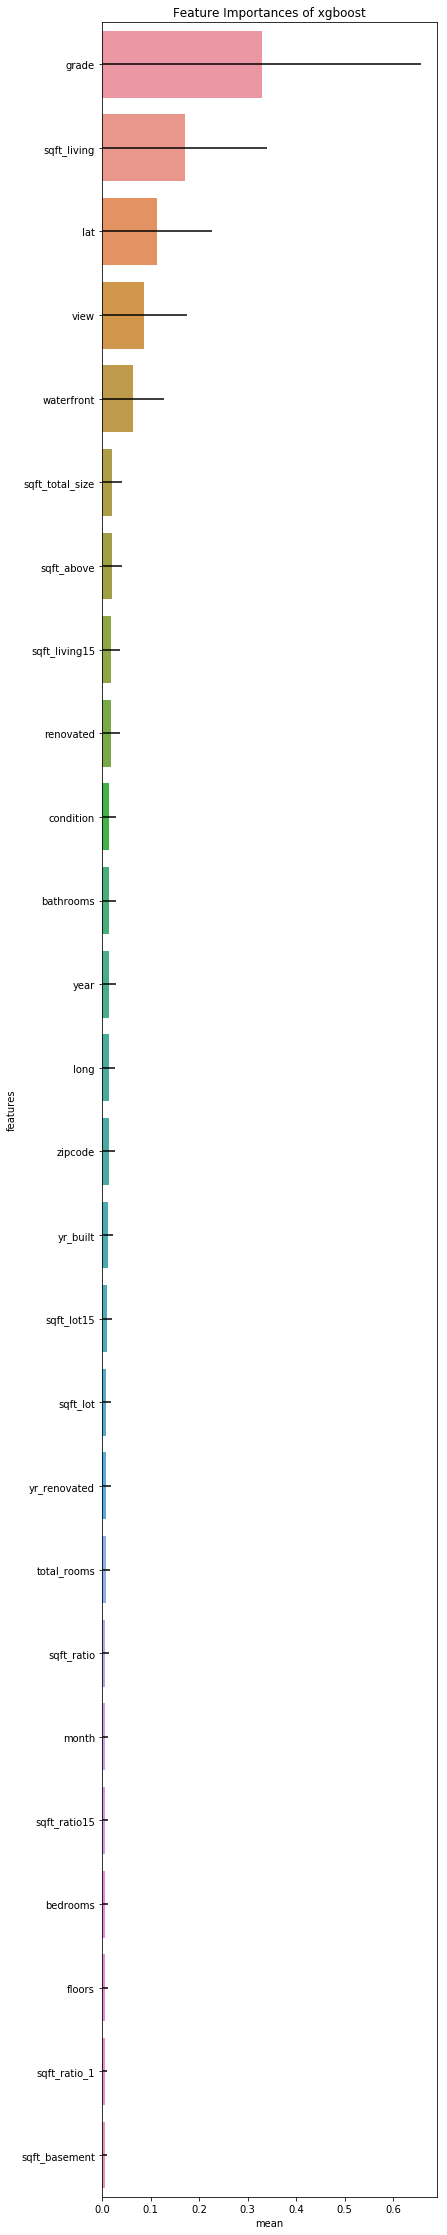

In [82]:
valid_score, predictions = model_xgb(X_train=X_adj_log_train,X_test=X_adj_log_test,y_train=y_adj_log_train,hyperparameters=tuned_params,logarithm=True,nfolds=10)

In [83]:
target = "xgb_uni_10"
scores_dict[target] = valid_score
predictions_dict[target] = predictions

In [84]:
submission = pd.read_csv(PATH+"sample_submission.csv")
submission["price"] = predictions
submission.to_csv("xgb_uni_layer_10.csv",index=False)

## <a id='52'>LGBMRegressor</a>  

아래의 코드는 fold별로 stacking을 다르게 하는 LightGBM모델을 사용하기 위한 함수입니다.

In [85]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import mean_squared_error

# price를 로그화 하기 전에 사용했던 lighgbm평가 함수
def lgb_rmse(y,preds):
    
    score = np.sqrt(mean_squared_error(y,preds))
  
    return "lgb_rmse",score,False

# price를 로그화 한 후에 사용하는 lightgbm평가 함수
def log_lgb_rmse(y,preds):
    
    score = np.sqrt(mean_squared_error(np.expm1(y),np.expm1(preds)))
  
    return "lgb_rmse",score,False

# lightgbm 실행함수
def model_lgb(X_train,y_train,X_test,nfolds=5,hyperparameters=None,logarithm=False):
    
    feature_names = X_train.columns.values
    
    valid_scores = np.zeros(len(X_train))
    predictions = np.zeros(len(X_test))
    
    valid_scores_list = []
    
    importances = np.zeros(len(feature_names))
    
    feature_importance_df = pd.DataFrame()
    feature_importance_df["features"] = feature_names
    
    if hyperparameters:
        params = hyperparameters
      
    else:
        params = {'boosting_type': 'gbdt',
                 'class_weight': None,
                 'colsample_bytree': 1.0,
                 'importance_type': 'split',
                 'learning_rate': 0.1,
                 'max_depth': -1,
                 'min_child_samples': 20,
                 'min_child_weight': 0.001,
                 'min_split_gain': 0.0,
                 'n_estimators': 1000,
                 'n_jobs': -1,
                 'num_leaves': 31,
                 'objective': "rmse",
                 'random_state': 101,
                 'reg_alpha': 0.0,
                 'reg_lambda': 0.0,
                 'silent': True,
                 'subsample': 1.0,
                 'subsample_for_bin': 200000,
                 'subsample_freq': 0}
    
    lgbr = lgb.LGBMRegressor(**params)
    
    if logarithm:
        fold = KFold(n_splits=nfolds,shuffle=True,random_state=12)
        e_metric = log_lgb_rmse
    else:
        fold = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=12)
        e_metric = lgb_rmse
    
    print(params)
    
    for i,(train_indices,valid_indices) in enumerate(fold.split(X_train.values,y_train.values)):
        
        X = X_train.values[train_indices]
        y = y_train.values[train_indices]
        X_valid = X_train.values[valid_indices]
        y_valid = y_train.values[valid_indices]
        
        print("{} fold processing".format(i+1),"#"*20)
        
        lgbr.fit(X,y,eval_set=[(X,y),(X_valid,y_valid)],eval_names=["train","valid"],eval_metric=e_metric,verbose=500,early_stopping_rounds=250)
        
        valid_scores_list.append(lgbr.best_score_["valid"]["lgb_rmse"])

        feature_importance_df[f"{i+1}"] = lgbr.feature_importances_
        
        if logarithm:
            valid_score = np.expm1(lgbr.predict(X_valid))
            prediction = np.expm1(lgbr.predict(X_test))
        
        else:
            valid_score = lgbr.predict(X_valid)
            prediction = lgbr.predict(X_test)
        
        valid_scores[valid_indices] += valid_score
        predictions += prediction / nfolds
        
    valid_mean_score = np.mean(valid_scores_list)
    
    print(f"mean_valid_score is {valid_mean_score} at {nfolds}")
    
    feature_importance_df["mean"] = feature_importance_df[feature_importance_df.columns.values[1:]].mean(axis=1)
    feature_importance_df["std"] = feature_importance_df[feature_importance_df.columns.values[1:]].mean(axis=1)
    
    fi_sorted = feature_importance_df.sort_values("mean",ascending=False)
    
    plt.figure(figsize=[6,40])
    sns.barplot(x="mean",y="features",data=fi_sorted,xerr=fi_sorted["std"])
    plt.title("Feature Importances of lightgbm",fontsize=12)
    plt.show()
        
    return valid_mean_score, predictions


In [86]:
tuned_params = {
    'boosting_type': 'gbrt',
    'class_weight': None,
    'colsample_bytree': 0.8424667117862588,
    'learning_rate': 0.11657835160316778,
    'max_depth': 21,
    'min_child_samples': 30,
    'min_child_weight': 2.7488547729054593,
    'n_estimators': 2160, #1080
    'num_leaves': 9,
    'objective': 'regression',
    'random_state': 101,
    'reg_alpha': 0.6915673059398951,
    'reg_lambda': 0.6362045095817355,
    'subsample': 0.8931910384738333,
    'subsample_for_bin': 100000,
    'subsample_freq': 4}

Stacking하는 폴드수를 5개로 했을 때 lightgbm의 활용

{'boosting_type': 'gbrt', 'class_weight': None, 'colsample_bytree': 0.8424667117862588, 'learning_rate': 0.11657835160316778, 'max_depth': 21, 'min_child_samples': 30, 'min_child_weight': 2.7488547729054593, 'n_estimators': 2160, 'num_leaves': 9, 'objective': 'regression', 'random_state': 101, 'reg_alpha': 0.6915673059398951, 'reg_lambda': 0.6362045095817355, 'subsample': 0.8931910384738333, 'subsample_for_bin': 100000, 'subsample_freq': 4}
1 fold processing ####################
Training until validation scores don't improve for 250 rounds.
[500]	train's l2: 0.016725	train's lgb_rmse: 90901.2	valid's l2: 0.0263915	valid's lgb_rmse: 125982
[1000]	train's l2: 0.0123254	train's lgb_rmse: 74860.9	valid's l2: 0.0259824	valid's lgb_rmse: 122500
Early stopping, best iteration is:
[1008]	train's l2: 0.0122715	train's lgb_rmse: 74676.5	valid's l2: 0.0259445	valid's lgb_rmse: 122433
2 fold processing ####################
Training until validation scores don't improve for 250 rounds.
[500]	train'

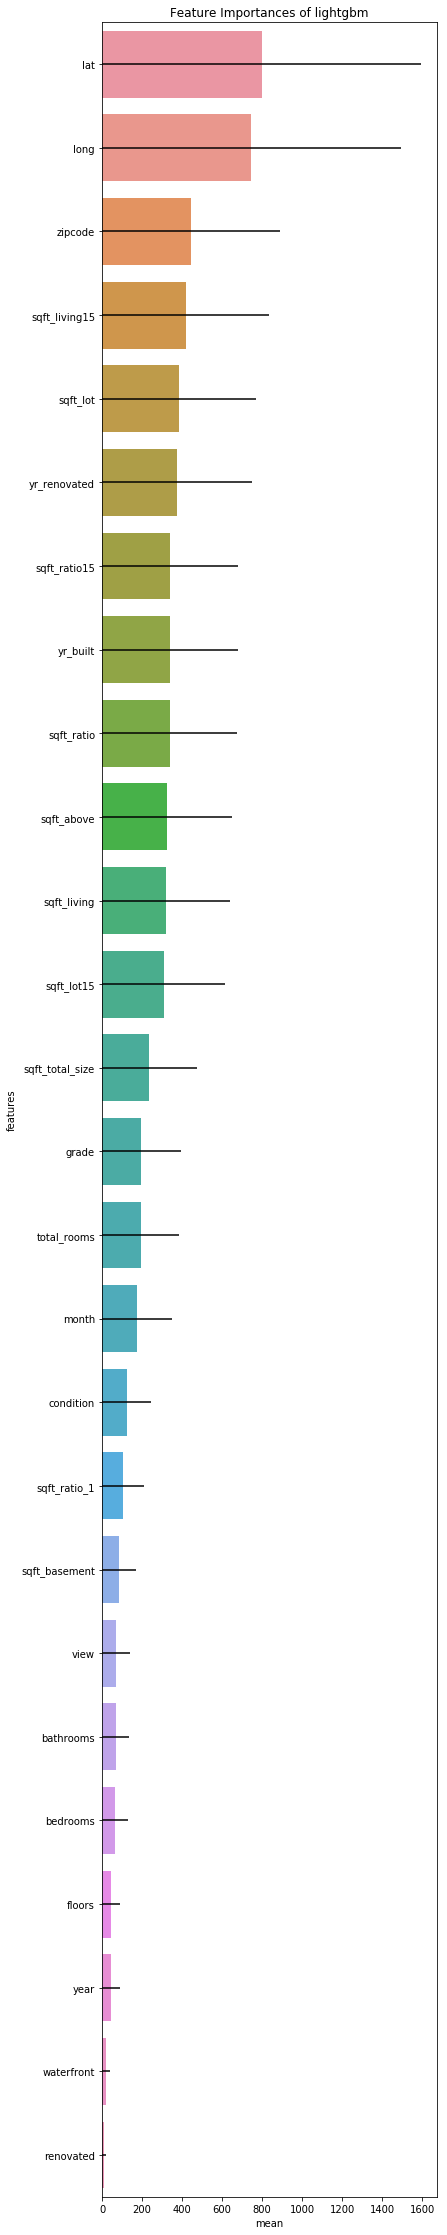

In [87]:
valid_score, predictions = model_lgb(X_train=X_adj_log_train,X_test=X_adj_log_test,y_train=y_adj_log_train,hyperparameters=tuned_params,logarithm=True)

In [88]:
target = "lgb_uni_5"
scores_dict[target] = valid_score
predictions_dict[target] = predictions

In [89]:
submission = pd.read_csv(PATH+"sample_submission.csv")
submission["price"] = predictions
submission.to_csv("lgb_uni_layer_5.csv",index=False)

Stacking하는 폴드수를 10개로 했을 때 lightgbm의 활용

{'boosting_type': 'gbrt', 'class_weight': None, 'colsample_bytree': 0.8424667117862588, 'learning_rate': 0.11657835160316778, 'max_depth': 21, 'min_child_samples': 30, 'min_child_weight': 2.7488547729054593, 'n_estimators': 2160, 'num_leaves': 9, 'objective': 'regression', 'random_state': 101, 'reg_alpha': 0.6915673059398951, 'reg_lambda': 0.6362045095817355, 'subsample': 0.8931910384738333, 'subsample_for_bin': 100000, 'subsample_freq': 4}
1 fold processing ####################
Training until validation scores don't improve for 250 rounds.
[500]	train's l2: 0.0171877	train's lgb_rmse: 90633.5	valid's l2: 0.0274441	valid's lgb_rmse: 127899
[1000]	train's l2: 0.0129011	train's lgb_rmse: 75826.7	valid's l2: 0.0268277	valid's lgb_rmse: 124640
[1500]	train's l2: 0.0103217	train's lgb_rmse: 67094.7	valid's l2: 0.0267039	valid's lgb_rmse: 122684
Early stopping, best iteration is:
[1520]	train's l2: 0.0102326	train's lgb_rmse: 66792.9	valid's l2: 0.0266615	valid's lgb_rmse: 122397
2 fold proc

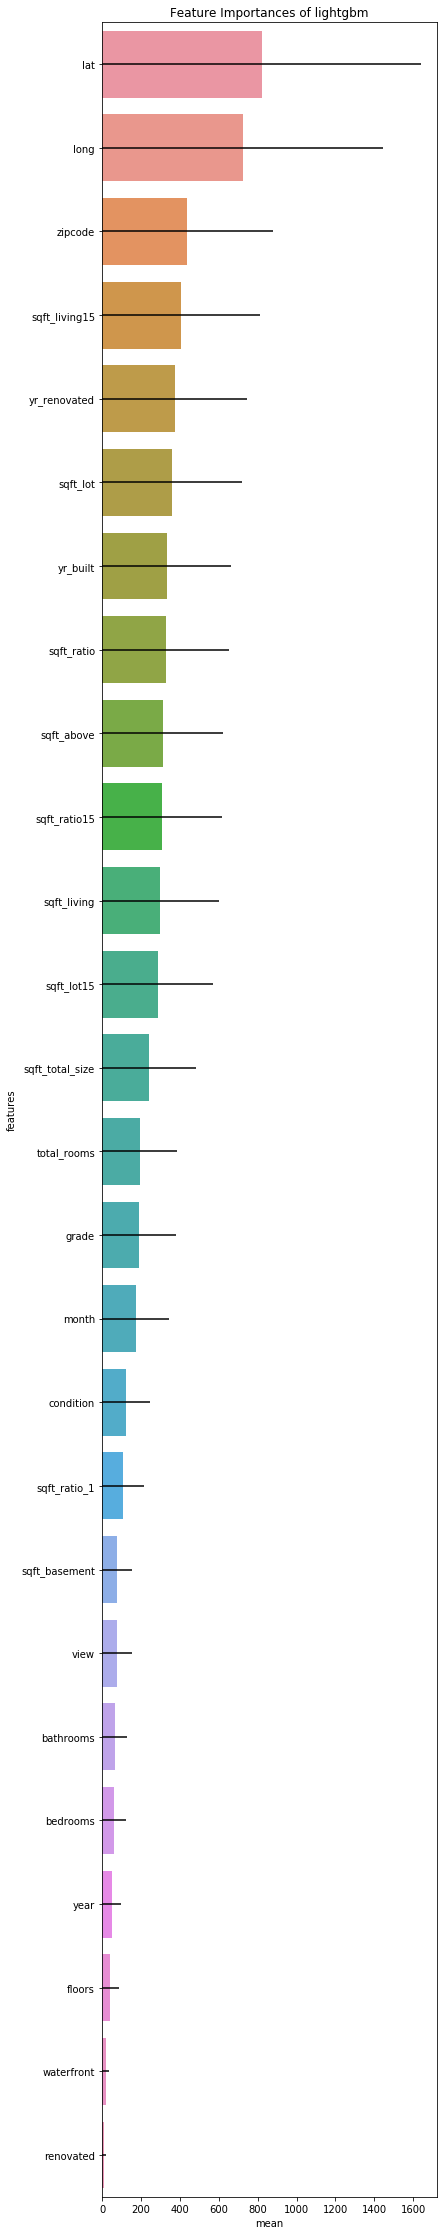

In [90]:
valid_score, predictions = model_lgb(X_train=X_adj_log_train,X_test=X_adj_log_test,y_train=y_adj_log_train,hyperparameters=tuned_params,logarithm=True,nfolds=10)

In [91]:
target = "lgb_uni_10"
scores_dict[target] = valid_score
predictions_dict[target] = predictions

In [92]:
submission = pd.read_csv(PATH+"sample_submission.csv")
submission["price"] = predictions
submission.to_csv("lgb_uni_layer_10.csv",index=False)

아래의 코드는 fold별로 stacking을 다르게 하며 seeds를 줌으로써 여러개의 random_state를 활용하여 얻어낸 다른 모델들을 한번 더 stacking한 LightGBM모델을 사용하기 위한 함수입니다.

In [93]:
def multiple_model_lgb(X_train,y_train,X_test,nfolds=5,hyperparameters=None,logarithm=False,seeds=[101]):
    
    #훈련에사용하는 컬럼들
    feature_names = X_train.columns.values
    
    #seed별로 모델의 feature_importance 저장을 위한 딕셔너리
    lgb_fi_dict = dict()
    #stack된 예측값을 저장하기 위한 변수
    stacked_predictions = np.zeros(len(X_test))
    #stack된 모델들의 점수를 모아두기 위한 배열
    total_best_valid_scores = []
    
    #시드별로 모델을 생성하며 모델에 대한 feature_importance, 예측값 그리고 valid_score를 위의 변수들에 기록함.  
    for k,seed in enumerate(seeds):

        valid_scores = np.zeros(len(X_train))
        predictions = np.zeros(len(X_test))

        best_valid_scores = []

        importances = np.zeros(len(feature_names))

        feature_importance_df = pd.DataFrame()
        feature_importance_df["features"] = feature_names

        if hyperparameters:
            params = hyperparameters

        else:
            params = {'boosting_type': 'gbdt',
                     'class_weight': None,
                     'colsample_bytree': 1.0,
                     'importance_type': 'split',
                     'learning_rate': 0.1,
                     'max_depth': -1,
                     'min_child_samples': 20,
                     'min_child_weight': 0.001,
                     'min_split_gain': 0.0,
                     'n_estimators': 1000,
                     'n_jobs': -1,
                     'num_leaves': 31,
                     'objective': "rmse",
                     'random_state': 101,
                     'reg_alpha': 0.0,
                     'reg_lambda': 0.0,
                     'silent': True,
                     'subsample': 1.0,
                     'subsample_for_bin': 200000,
                     'subsample_freq': 0}

        params["random_state"] = seed
        
        lgbr = lgb.LGBMRegressor(**params)

        if logarithm:
            fold = KFold(n_splits=nfolds,shuffle=True,random_state=12)
            e_metric = log_lgb_rmse
        else:
            fold = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=12)
            e_metric = lgb_rmse

        print(f"Current seed is {seed} of {k+1} elements","#"*15)
        print(params)

        for i,(train_indices,valid_indices) in enumerate(fold.split(X_train.values,y_train.values)):

            X = X_train.values[train_indices]
            y = y_train.values[train_indices]
            X_valid = X_train.values[valid_indices]
            y_valid = y_train.values[valid_indices]

            print("{} fold processing".format(i+1),"#"*20)

            lgbr.fit(X,y,eval_set=[(X,y),(X_valid,y_valid)],eval_names=["train","valid"],eval_metric=e_metric,verbose=500,early_stopping_rounds=250)

            best_valid_scores.append(lgbr.best_score_["valid"]["lgb_rmse"])

            feature_importance_df[f"{i+1}"] = lgbr.feature_importances_

            if logarithm:
                valid_score = np.expm1(lgbr.predict(X_valid))
                prediction = np.expm1(lgbr.predict(X_test))

            else:
                valid_score = lgbr.predict(X_valid)
                prediction = lgbr.predict(X_test)

            valid_scores[valid_indices] += valid_score
            predictions += prediction / nfolds

        valid_mean_score = np.mean(best_valid_scores)    
        print(f"mean_valid_score is {valid_mean_score} at {nfolds}")
        total_best_valid_scores.append(valid_mean_score)
    
        feature_importance_df["mean"] = feature_importance_df[feature_importance_df.columns.values[1:]].mean(axis=1)
        feature_importance_df["std"] = feature_importance_df[feature_importance_df.columns.values[1:]].mean(axis=1)
    
        lgb_fi_dict[seed] = feature_importance_df
        stacked_predictions += predictions / len(seeds)
    
    #stacking된 결과 값들을 저장하고 plot을 그리거나 return해주기 위한 과정.
    
    stacked_importances = pd.DataFrame()
    stacked_importances["features"] = feature_names
    stacked_importances["mean"] = 0
    stacked_importances["std"] = 0
    
    for key,values in lgb_fi_dict.items():
        stacked_importances["mean"] += values["mean"]/len(seeds)
        stacked_importances["std"] += values["std"]/len(seeds)
    
    fi_sorted= stacked_importances.sort_values(by="mean",ascending=False)
    
    stacked_valid_mean_score = np.mean(total_best_valid_scores)
    
    print(f"Stacked valid_score of {seeds} is {stacked_valid_mean_score} at {nfolds}")
    
    plt.figure(figsize=[6,40])
    sns.barplot(x="mean",y="features",data=fi_sorted,xerr=fi_sorted["std"])
    plt.title("Feature Importances of lightgbm",fontsize=12)
    plt.show()
        
    return stacked_valid_mean_score,stacked_predictions


아래에 해당하는 5개의 seed들은 필자가 임의로 지정하였으며 원래 훈련을 진행했던 101시드를 포함하였습니다. 그리고 5개의 시드를 활용한 5폴드로 교차검증하는 모델을 살펴봅니다.

Current seed is 101 of 1 elements ###############
{'boosting_type': 'gbrt', 'class_weight': None, 'colsample_bytree': 0.8424667117862588, 'learning_rate': 0.11657835160316778, 'max_depth': 21, 'min_child_samples': 30, 'min_child_weight': 2.7488547729054593, 'n_estimators': 2160, 'num_leaves': 9, 'objective': 'regression', 'random_state': 101, 'reg_alpha': 0.6915673059398951, 'reg_lambda': 0.6362045095817355, 'subsample': 0.8931910384738333, 'subsample_for_bin': 100000, 'subsample_freq': 4}
1 fold processing ####################
Training until validation scores don't improve for 250 rounds.
[500]	train's l2: 0.016725	train's lgb_rmse: 90901.2	valid's l2: 0.0263915	valid's lgb_rmse: 125982
[1000]	train's l2: 0.0123254	train's lgb_rmse: 74860.9	valid's l2: 0.0259824	valid's lgb_rmse: 122500
Early stopping, best iteration is:
[1008]	train's l2: 0.0122715	train's lgb_rmse: 74676.5	valid's l2: 0.0259445	valid's lgb_rmse: 122433
2 fold processing ####################
Training until validation

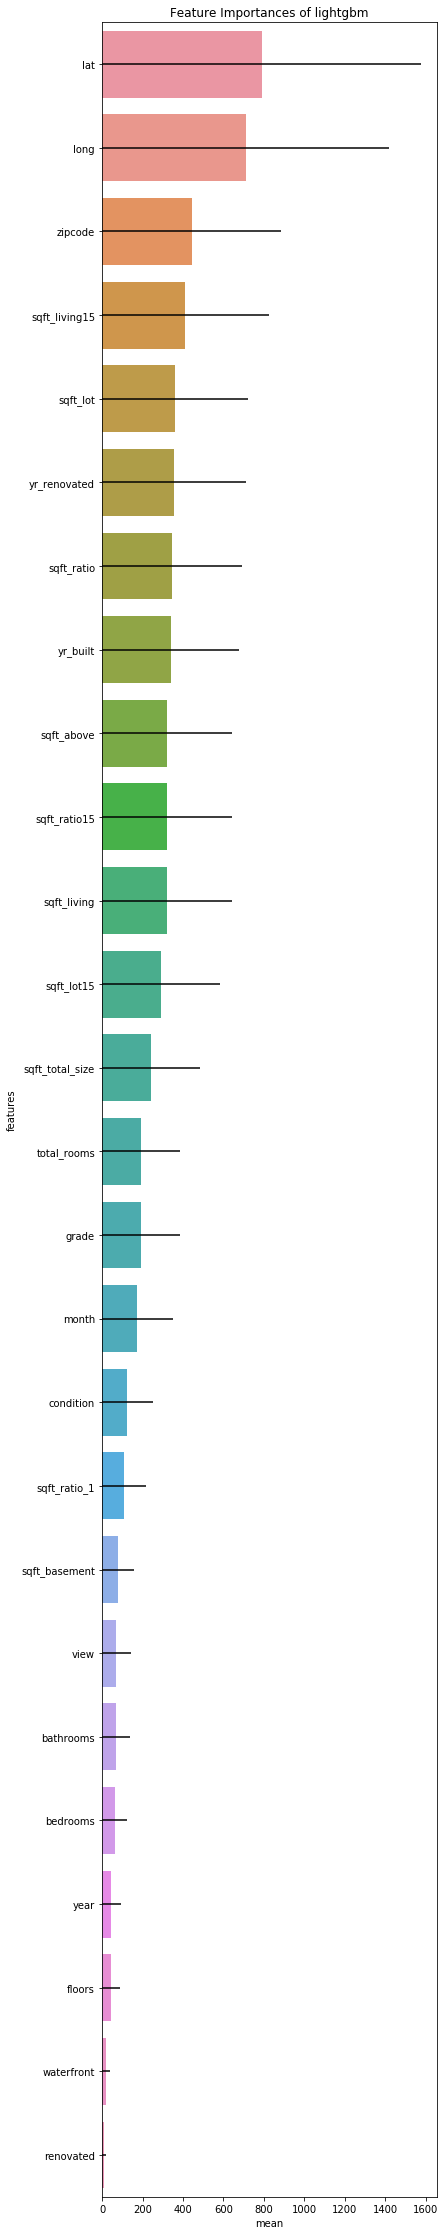

In [94]:
valid_score, predictions = multiple_model_lgb(X_train=X_adj_log_train,X_test=X_adj_log_test,y_train=y_adj_log_train,hyperparameters=tuned_params,logarithm=True,seeds=[101,200,27,1085,567])

In [95]:
target = "lgb_multiple_5"
scores_dict[target] = valid_score
predictions_dict[target] = predictions

In [96]:
submission = pd.read_csv(PATH+"sample_submission.csv")
submission["price"] = predictions
submission.to_csv("lgb_multiple_layer_5.csv",index=False)

아래에 해당하는 5개의 seed들은 필자가 임의로 지정하였으며 원래 훈련을 진행했던 101시드를 포함하였습니다. 그리고 5개의 시드를 활용한 10폴드로 교차검증하는 모델을 살펴봅니다.

Current seed is 101 of 1 elements ###############
{'boosting_type': 'gbrt', 'class_weight': None, 'colsample_bytree': 0.8424667117862588, 'learning_rate': 0.11657835160316778, 'max_depth': 21, 'min_child_samples': 30, 'min_child_weight': 2.7488547729054593, 'n_estimators': 2160, 'num_leaves': 9, 'objective': 'regression', 'random_state': 101, 'reg_alpha': 0.6915673059398951, 'reg_lambda': 0.6362045095817355, 'subsample': 0.8931910384738333, 'subsample_for_bin': 100000, 'subsample_freq': 4}
1 fold processing ####################
Training until validation scores don't improve for 250 rounds.
[500]	train's l2: 0.0171877	train's lgb_rmse: 90633.5	valid's l2: 0.0274441	valid's lgb_rmse: 127899
[1000]	train's l2: 0.0129011	train's lgb_rmse: 75826.7	valid's l2: 0.0268277	valid's lgb_rmse: 124640
[1500]	train's l2: 0.0103217	train's lgb_rmse: 67094.7	valid's l2: 0.0267039	valid's lgb_rmse: 122684
Early stopping, best iteration is:
[1520]	train's l2: 0.0102326	train's lgb_rmse: 66792.9	valid's 

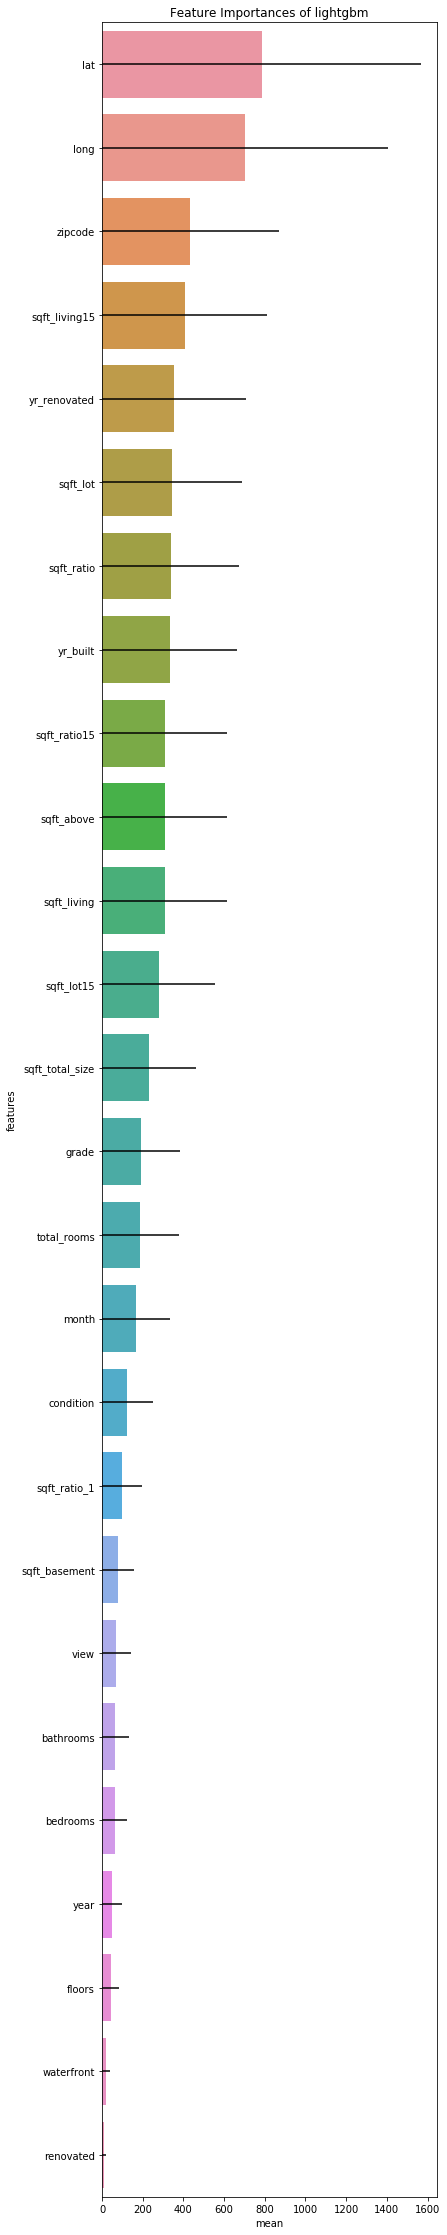

In [97]:
valid_score, predictions = multiple_model_lgb(X_train=X_adj_log_train,X_test=X_adj_log_test,y_train=y_adj_log_train,nfolds=10,hyperparameters=tuned_params,logarithm=True,seeds=[101,200,27,1085,567])

In [98]:
target = "lgb_multiple_10"
scores_dict[target] = valid_score
predictions_dict[target] = predictions

In [99]:
submission = pd.read_csv(PATH+"sample_submission.csv")
submission["price"] = predictions
submission.to_csv("lgb_multiple_layer_10.csv",index=False)

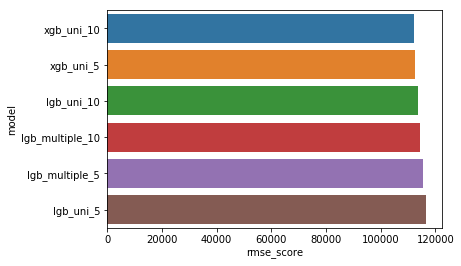

In [100]:
result_df = np.transpose(pd.DataFrame(scores_dict,index=range(1))).rename(columns={0:"rmse_score"}).sort_values(by="rmse_score")
result_df = result_df.reset_index().rename(columns={"index":"model"})
sns.barplot(x="rmse_score",y="model",data=result_df)

앙상블을 하게 되는 이유는 XGBoost와 lightGBM이 같은 결정트리기반의 부스팅 모델이라고 하더라도 둘의 학습의 지향점이 다르기 때문입니다.(정확히는 좀 더 공부해야 할 것 같습니다.)그러나 간단하게 대략적으로보면 우리가 앙상블로 사용하게 될 두 모델은 아래와 같습니다.

**1. xgb_uni_10** <br />
**2. lgb_multiple_10**

두 개의 모델의 feature_importance를 그린것을 살펴보면 이 둘의 결과를 나타내는 데 있어서 컬럼들의 중요도가 다르게 나타납니다. 이는 두 모델이 다른 관점을 지니고 있다는 것을 보여주기 떄문에 따라서 이 두 모델들 중 성능이 좋은 두 가지를 가지고 0.5씩 앙상블하였습니다.

In [101]:
target1 = "xgb_uni_10"
target2 = "lgb_multiple_10"

ensembled_predictions = predictions_dict[target1] * 0.5 + predictions_dict[target2] * 0.5
ensembled_score = scores_dict[target1] * 0.5 + scores_dict[target2] * 0.5

predictions_dict["ensemble1"] = ensembled_predictions
scores_dict["ensemble1"] = ensembled_score

submission = pd.read_csv(PATH+"sample_submission.csv")
submission["price"] = ensembled_predictions
submission.to_csv("xgb_lgb_ensemble.csv",index=False)

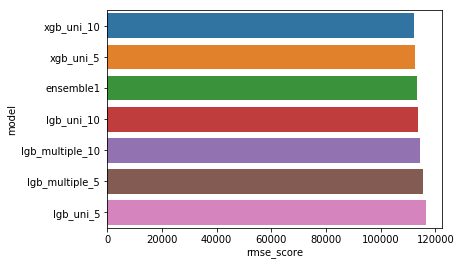

In [102]:
result_df = np.transpose(pd.DataFrame(scores_dict,index=range(1))).rename(columns={0:"rmse_score"}).sort_values(by="rmse_score")
result_df = result_df.reset_index().rename(columns={"index":"model"})
sns.barplot(x="rmse_score",y="model",data=result_df)

# <a id='6'>2차 대회를 통해 느낀점</a>

이번 대회를 통해 느낀점은 크게 두 가지입니다.
1. 데이터 전처리는 굉장히 중요한 항목이다.
2. 하이퍼파라미터 튜닝을 너무 믿지도 말고 가장 마지막에 수행해야 할 항목이다.

이번 대회를 통해 제가 데이터를 전처리하는 것을 좀 소홀히 생각하고 있다는 것을 느꼈습니다. 전처리 보다는 성능을 쥐어짜기에 급급한 stacking이나 hyperparameter를 튜닝하는 것을 배우고 적용하는데 급급했었던 것 같습니다. 하지만 "Garbage in, Garbage out" 즉, 최적의 성능을 내기 위해서는 모델의 학습을 위해 투입되는 데이터를 잘 걸러내지 않으면 최적의 결과를 얻을 수 없다는 것입니다. 이번 컴피티션을 통해 어느 일정수준의 Public Score에서 올리지 못했던 이유는 이 때문이라고 생각합니다. 따라서 이번 컴피티션이나 다른 컴피티션의 다른 분들의 커널을 볼 때에는 어떤 생각으로 피쳐들을 뽑아냈는지를 같이 생각하며 스스로 컬럼들을 만들어내고 정제하는 능력을 키워야겠다고 생각했습니다. 

두 번째로 데이터를 예측하는데 사용했던 XGBoost나 LightGBM의 하이퍼파라미터 튜닝에 너무 많은 시간을 소비했고, 마지막에 XGBoost를 같이 앙상블함으로써 겨우 성적을 얻어낸 것 같습니다. XGBoost를 사용하기 전에는 주구장창 Lightgbm이 옳을 거라고만 생각했기 때문이죠. 따라서 하나의 모델에만 집착하지 않는 사고를 가져야겠다고 생각했습니다. 물론 다른 모델을을 모두 실행하기에는 시간이 부족했다는 변명이지만, 다음에는 편협되지 않은 다양한 가능성을 열어둔 생각을 가지는 것이 중요하다고 생각했습니다.

마지막으로 지난 1차대회를 포함하여 2차대회까지 참가하면서 대회를 준비해주신 분들에게 감사의 말씀드립니다. 실제로 열리는 컴피티션에 참가하면서 공부하고 있지만 캐글코리아에서 준비해주시는 커널은 다른 컴피티션에서 배웠던 것들을 더 주체적으로 활용하는 시간이 되는 것 같습니다. 다음 3차대회도 오매불망 기다리면서 꾸준히 공부하고 있겠습니다. 

## KEEP GOING KAGGLE!!